In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed
import ipywidgets as widgets
from IPython.display import display
import pickle
import numpy as np

In [3]:
import stardistwrapper as sdw
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
lbl_cmap = random_label_cmap()

# Measure performance of StarDist on GT

## 0. Load & Prepare data

In [4]:
import h5py

path = 'data/GT/'
f = h5py.File(path+'GT_TrackID.h5','r+') # Track file
track = f['image'][:]
f.close()

f = h5py.File(path+'Plantseg_T29-39.h5','r+') # PlantSeg file
plantseg = f['image'][:]
f.close()

f = h5py.File(path+'C1mem_T29-39.h5','r+') # Raw file
c1 = f['image'][:]
f.close()

f = h5py.File(path+'C2ZO1_T29-39.h5','r+') # C2 file
c2 = f['image'][:]
f.close()

In [5]:
import h5py
from glob import glob
import numpy as np
from csbdeep.utils import Path, normalize
from tqdm import tqdm

def load_fatepredict_data(dataset, n_channel=3, norm=True):
    _path = path+'%s/data_*.h5' % dataset
    files = sorted(glob(_path))
    _X = []
    _Y = []
    
    for f in files:
        f = h5py.File(f, 'r')
        _X.append(f['X'][:])
        _Y.append(f['Y'][:])
        f.close()
    
    # Normalize
    if norm:
        ax = None
        if n_channel>1: ax=(0,1)
        _X = [normalize(x, 1, 99.8, axis=ax) for x in tqdm(_X)]
    
    # Split the dataset
    rng = np.random.RandomState(42)
    ind = rng.permutation(len(_X))
    
    n_val = max(1, int(round(0.15 * len(ind))))
    ind_train, ind_val = ind[:-n_val], ind[-n_val:]
    
    _X_val, _Y_val = [_X[i] for i in ind_val], [_Y[i] for i in ind_val]
    _X_trn, _Y_trn = [_X[i] for i in ind_train], [_Y[i] for i in ind_train]

    print('number of images: %3d' % len(_X))
    print('- training:       %3d' % len(_X_trn))
    print('- validation:     %3d' % len(_X_val))
    print(f"X[0].shape={_X[0].shape}")

    return _X, _Y, _X_trn, _Y_trn, _X_val, _Y_val, n_channel

### Slice data
The data will be sliced to be (Z, Y, X, C) = (20, 100, 100, 3) then saved in each individual timestep
Where C is the channels (CellMembranes, ZO1, PlantSeg)
Each file will contain X and Y, where X is the 3 channels, and Y is the GT fragments in the format (Z, Y, X) = (20, 100, 100)

In [6]:
max_t, *_ = c2.shape
slice_z = [0, 20]
slice_y = [0, 100]
slice_x = [0, 100]

## Model1
Use all 3 channels as training data

### Prepare data

In [5]:
for _t in range(max_t):
    for a, _z in enumerate(slice_z):
        for b, _y in enumerate(slice_y):
            for c, _x in enumerate(slice_x):
                ext = 'T%s_Z%s_Y%s_X%s' % (_t, a, b, c)
                file = 'train_m1/data_%s.h5' % ext
                #print(file)
                _c1 = c1[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _c2 = c2[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _plantseg = plantseg[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                
                _X = np.stack((_c1, _c2, _plantseg), axis=3) # StarDist requires the deepest axis to be the channels
                _Y = track[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _f = h5py.File(path+file, 'w') # Track file
                _f.create_dataset('X', data=_X)
                _f.create_dataset('Y', data=_Y)
                _f.close()

In [49]:
X, Y, X_trn, Y_trn, X_val, Y_val, n_channel = \
    load_fatepredict_data('train_m1')


100%|██████████| 88/88 [00:01<00:00, 58.67it/s]

number of images:  88
- training:        75
- validation:      13
X[0].shape=(20, 100, 100, 3)


### Visualize data

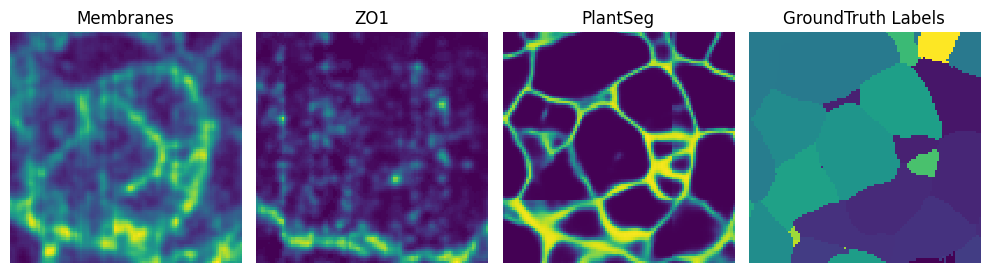

In [54]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 4

fig.add_subplot(rows, columns, 1)
plt.imshow(X[0][10,:,:,0], cmap='viridis')
plt.axis('off')
plt.title('Membranes')

fig.add_subplot(rows, columns, 2)
plt.imshow(X[0][10,:,:,1], cmap='viridis')
plt.axis('off')
plt.title('ZO1')

fig.add_subplot(rows, columns, 3)
plt.imshow(X[0][10,:,:,2], cmap='viridis')
plt.axis('off')
plt.title('PlantSeg')

fig.add_subplot(rows, columns, 4)
plt.imshow(Y[0][10,:,:])
plt.axis('off')
plt.title('GroundTruth Labels')

plt.tight_layout()
plt.savefig('exp2.1_training_data.png')
plt.show()

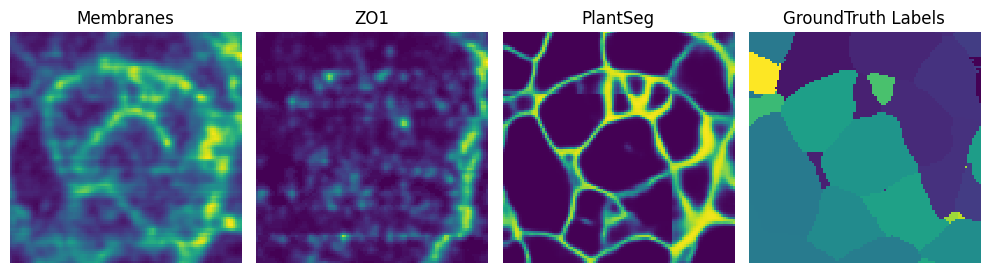

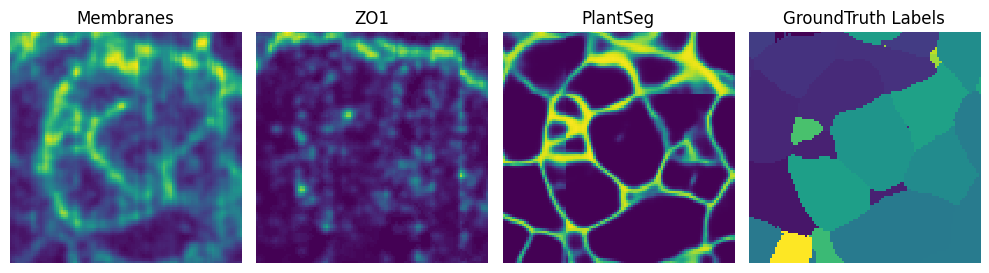

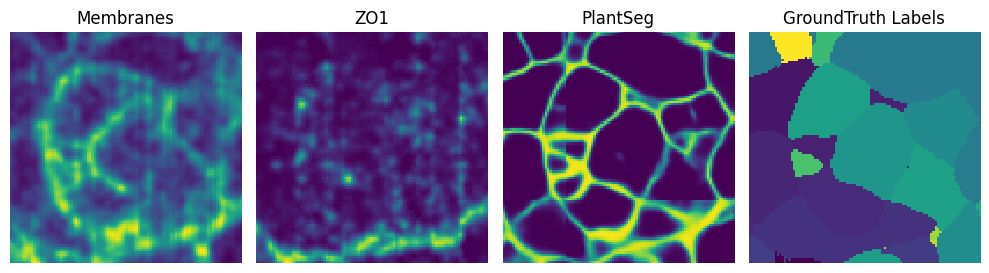

In [26]:
# plot some augmented examples
img, lbl = X[0],Y[0]

for i in range(3):
    img_aug, lbl_aug = sdw.augmenter(img,lbl)
    
    fig = plt.figure(figsize=(10, 3))

    rows = 1
    columns = 4
    
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img_aug[10,:,:,0], cmap='viridis')
    plt.axis('off')
    plt.title('Membranes')
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(img_aug[10,:,:,1], cmap='viridis')
    plt.axis('off')
    plt.title('ZO1')
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(img_aug[10,:,:,2], cmap='viridis')
    plt.axis('off')
    plt.title('PlantSeg')
    
    fig.add_subplot(rows, columns, 4)
    plt.imshow(lbl_aug[10,:,:])
    plt.axis('off')
    plt.title('GroundTruth Labels')
    plt.tight_layout()
    plt.savefig('exp2.1_training_data_augmented_%s.png' % i)
    plt.show()

### Configure + train

In [ ]:
model_name="fatepredict_small_model1"
model = sdw.configure(Y, n_channel, model_name=model_name)

model_hist = model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=sdw.augmenter, epochs=1000)

empirical anisotropy of labeled objects = (1.8181818181818181, 1.0256410256410255, 1.0)
If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
div_by=(4, 8, 8)
n_dim: 3
axes: ZYXC
n_channel_in: 3
n_channel_out: 97
train_checkpoint: weights_best.h5
train_checkpoint_last: weights_last.h5
train_checkpoint_epoch: weights_now.h5
n_rays: 96
grid: (1, 2, 2)
anisotropy: (1.8181818181818181, 1.0256410256410255, 1.0)
backbone: unet
rays_json: {'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.8181818181818181, 1.0256410256410255, 1.0)}}
n_classes: None
unet_n_depth: 2
unet_kernel_size: (3, 3, 3)
unet_n_filter_base: 32
unet_n_conv_per_depth: 2
unet_pool: (2, 2, 2)
unet_activation: relu
unet_last_activation: relu
unet_batch_norm: False
unet_dropout: 0.0
unet_prefix: 
net_conv_after_unet: 128
net_input_shape: (None, None, None, 3)
net_mask_shape: (None, None, None, 1)
train_patch_size: [20, 32, 32]
train_background_reg: 0.0001
train_for

base_model.py (149): output path for model already exists, files may be overwritten: /home/jupyter/fatepredict/experiments/stardist_models/fatepredict_small_model1
2023-12-02 09:21:07.968016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 09:21:11.541088: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 09:21:11.543260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but ther

Using default values: prob_thresh=0.5, nms_thresh=0.4.


2023-12-02 09:21:45.328052: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900


median object size:      [11.  19.5 20. ]
network field of view :  [26 46 46]
Epoch 1/1000
Cause: Unable to locate the source code of <function _gcd_import at 0x7f38d111b400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f38d111b400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f38d111b400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-12-02 09:22:44.115337: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3236183070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 09:22:44.115377: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-12-02 09:22:44.639679: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701508965.271585    4433 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 24s 64ms/step - loss: 2.0659 - prob_loss: 0.6338 - dist_loss: 7.1608 - prob_kld: 0.1146 - dist_relevant_mae: 7.1606 - dist_relevant_mse: 85.8427 - dist_dist_iou_metric: 0.0885 - val_loss: 1.6185 - val_prob_loss: 0.6220 - val_dist_loss: 4.9825 - val_prob_kld: 0.1112 - val_dist_relevant_mae: 4.9821 - val_dist_relevant_mse: 50.4508 - val_dist_dist_iou_metric: 0.1951 - lr: 3.0000e-04
Epoch 2/1000
100/100 [==============================] - 4s 38ms/step - loss: 1.4782 - prob_loss: 0.6288 - dist_loss: 4.2474 - prob_kld: 0.1061 - dist_relevant_mae: 4.2469 - dist_relevant_mse: 37.2292 - dist_dist_iou_metric: 0.2963 - val_loss: 1.3496 - val_prob_loss: 0.6106 - val_dist_loss: 3.6951 - val_prob_kld: 0.0999 - val_dist_relevant_mae: 3.6947 - val_dist_relevant_mse: 29.5603 - val_dist_dist_iou_metric: 0.3415 - lr: 3.0000e-04
Epoch 3/1000
100/100 [==============================] - 4s 39ms/step - loss: 1.2439 - prob_loss: 0.5961 - dist_loss: 3.2391 - prob_kld: 

### Training graph

In [10]:
import pickle
pickle.dump(model_hist, open('model1_hist.pkl', 'wb'))

In [21]:
import pickle
pickle.load(model_hist, open('model1_hist.pkl', 'rb'))

NameError: name 'model_hist' is not defined

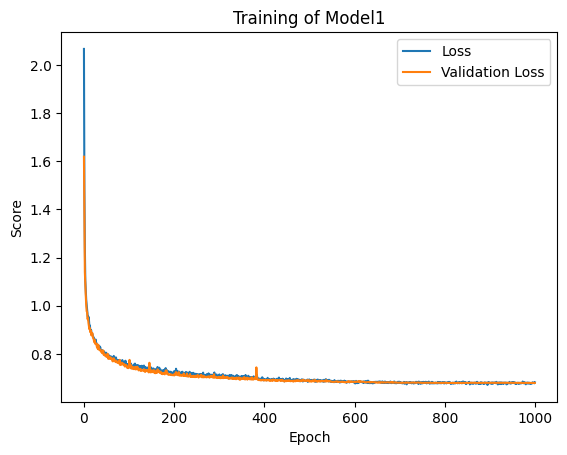

In [15]:
plt.figure()
plt.plot(model_hist.history['loss'], label='Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')

plt.title('Training of Model1')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()
plt.savefig('exp2.1_training.png')

### Predict + Visualize output

In [51]:
model_name="fatepredict_small_model1"
model = sdw.load_stardist_model(model_name=model_name)

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_small_model1' from folder 'stardist_models'


In [ ]:
Y_val_pred1 = [model.predict_instances(x, show_tile_progress=False)[0][0]
              for x in tqdm(X_val)]




  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step





  8%|▊         | 1/13 [00:32<06:28, 32.37s/it]

1/1 [==============================] - 0s 26ms/step





 15%|█▌        | 2/13 [01:12<06:46, 36.91s/it]

1/1 [==============================] - 0s 26ms/step





 23%|██▎       | 3/13 [01:57<06:45, 40.56s/it]

1/1 [==============================] - 0s 27ms/step





 31%|███       | 4/13 [02:37<06:03, 40.43s/it]

1/1 [==============================] - 0s 25ms/step





 38%|███▊      | 5/13 [03:10<05:01, 37.65s/it]

1/1 [==============================] - 0s 29ms/step





 46%|████▌     | 6/13 [03:43<04:12, 36.03s/it]

1/1 [==============================] - 0s 26ms/step





 54%|█████▍    | 7/13 [04:17<03:32, 35.41s/it]

1/1 [==============================] - 0s 26ms/step





 62%|██████▏   | 8/13 [04:54<03:00, 36.10s/it]

1/1 [==============================] - 0s 26ms/step





 69%|██████▉   | 9/13 [05:25<02:18, 34.52s/it]

1/1 [==============================] - 0s 28ms/step





 77%|███████▋  | 10/13 [06:10<01:52, 37.62s/it]

1/1 [==============================] - 0s 26ms/step





 85%|████████▍ | 11/13 [06:42<01:11, 35.81s/it]

1/1 [==============================] - 0s 26ms/step





 92%|█████████▏| 12/13 [07:14<00:34, 34.87s/it]

1/1 [==============================] - 0s 25ms/step





100%|██████████| 13/13 [07:52<00:00, 36.33s/it]


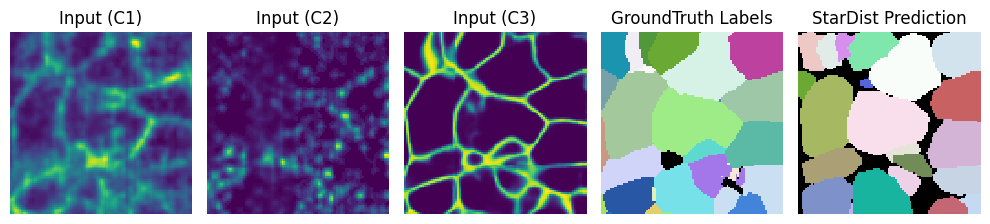

In [53]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 5

fig.add_subplot(rows, columns, 1)
plt.imshow(X_val[0][10][:,:,0])
plt.axis('off')
plt.title('Input (C1)')

fig.add_subplot(rows, columns, 2)
plt.imshow(X_val[0][10][:,:,1])
plt.axis('off')
plt.title('Input (C2)')

fig.add_subplot(rows, columns, 3)
plt.imshow(X_val[0][10][:,:,2])
plt.axis('off')
plt.title('Input (C3)')

fig.add_subplot(rows, columns, 4)
plt.imshow(Y_val[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels')

fig.add_subplot(rows, columns, 5)
plt.imshow(Y_val_pred1[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('StarDist Prediction')

plt.tight_layout()
plt.savefig('exp2.1_model1_stardist_pred.png')
plt.show()


### Measure performance

In [76]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats1 = [matching_dataset(Y_val, Y_val_pred1, thresh=t, show_progress=False) for t in tqdm(taus)]




  0%|          | 0/1 [44:20<?, ?it/s]



 11%|█         | 1/9 [00:01<00:08,  1.12s/it]


 22%|██▏       | 2/9 [00:01<00:03,  1.86it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.83it/s]


 44%|████▍     | 4/9 [00:01<00:01,  3.76it/s]


 56%|█████▌    | 5/9 [00:01<00:00,  4.58it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  5.23it/s]


 78%|███████▊  | 7/9 [00:01<00:00,  5.72it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  6.14it/s]


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


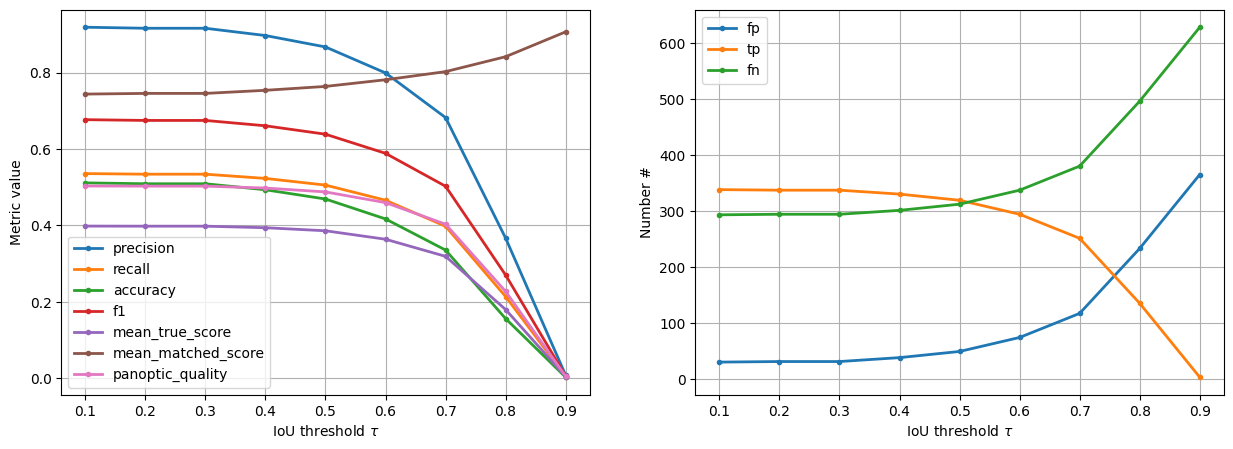

In [210]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats1], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats1], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.savefig('exp2.1_iou_pr_stardist_model1.png')

## Model2
Train on raw + PlantSeg

### Prepare data

In [40]:
for _t in range(max_t):
    for a, _z in enumerate(slice_z):
        for b, _y in enumerate(slice_y):
            for c, _x in enumerate(slice_x):
                ext = 'T%s_Z%s_Y%s_X%s' % (_t, a, b, c)
                file = 'train_m2/data_%s.h5' % ext
                #print(file)
                _c1 = c1[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _c2 = c2[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _plantseg = plantseg[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                
                _X = np.stack((_c1, _plantseg), axis=3) # StarDist requires the deepest axis to be the channels
                _Y = track[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _f = h5py.File(path+file, 'w') # Track file
                _f.create_dataset('X', data=_X)
                _f.create_dataset('Y', data=_Y)
                _f.close()

In [46]:
X2, Y2, X_trn2, Y_trn2, X_val2, Y_val2, n_channel2 = \
    load_fatepredict_data('train_m2', n_channel=2)


100%|██████████| 88/88 [00:01<00:00, 81.43it/s]

number of images:  88
- training:        75
- validation:      13
X[0].shape=(20, 100, 100, 2)


### Visualize data

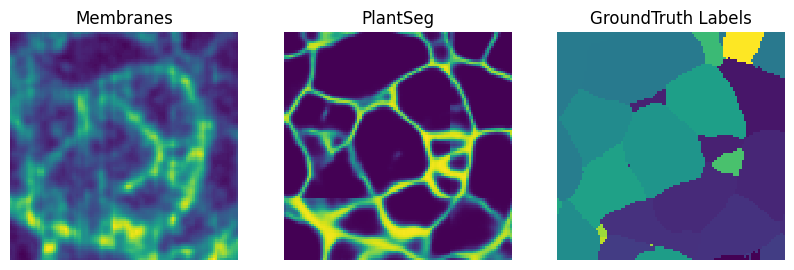

In [63]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(X2[0][10,:,:,0], cmap='viridis')
plt.axis('off')
plt.title('Membranes')

fig.add_subplot(rows, columns, 2)
plt.imshow(X2[0][10,:,:,1], cmap='viridis')
plt.axis('off')
plt.title('PlantSeg')

fig.add_subplot(rows, columns, 3)
plt.imshow(Y2[0][10,:,:])
plt.axis('off')
plt.title('GroundTruth Labels')
plt.savefig('exp2.2_training_data.png')
plt.show()

### Configure + train

In [ ]:
model_name2="fatepredict_small_model2"
model2 = sdw.configure(Y2, n_channel2, model_name=model_name2)

model2_hist = model2.train(X_trn2, Y_trn2, validation_data=(X_val2,Y_val2), augmenter=sdw.augmenter, epochs=1000)

empirical anisotropy of labeled objects = (1.8181818181818181, 1.0256410256410255, 1.0)
div_by=(4, 8, 8)
n_dim: 3
axes: ZYXC
n_channel_in: 2
n_channel_out: 97
train_checkpoint: weights_best.h5
train_checkpoint_last: weights_last.h5
train_checkpoint_epoch: weights_now.h5
n_rays: 96
grid: (1, 2, 2)
anisotropy: (1.8181818181818181, 1.0256410256410255, 1.0)
backbone: unet
rays_json: {'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.8181818181818181, 1.0256410256410255, 1.0)}}
n_classes: None
unet_n_depth: 2
unet_kernel_size: (3, 3, 3)
unet_n_filter_base: 32
unet_n_conv_per_depth: 2
unet_pool: (2, 2, 2)
unet_activation: relu
unet_last_activation: relu
unet_batch_norm: False
unet_dropout: 0.0
unet_prefix: 
net_conv_after_unet: 128
net_input_shape: (None, None, None, 2)
net_mask_shape: (None, None, None, 1)
train_patch_size: [20, 32, 32]
train_background_reg: 0.0001
train_foreground_only: 0.9
train_sample_cache: True
train_dist_loss: mae
train_loss_weights: (1, 0.2)
train_cla

base_model.py (149): output path for model already exists, files may be overwritten: /home/jupyter/fatepredict/experiments/stardist_models/fatepredict_small_model2


median object size:      [11.  19.5 20. ]
network field of view :  [26 46 46]
Epoch 1/1000
100/100 [==============================] - 10s 56ms/step - loss: 1.9895 - prob_loss: 0.6400 - dist_loss: 6.7474 - prob_kld: 0.1175 - dist_relevant_mae: 6.7471 - dist_relevant_mse: 78.0162 - dist_dist_iou_metric: 0.1048 - val_loss: 1.5627 - val_prob_loss: 0.6244 - val_dist_loss: 4.6914 - val_prob_kld: 0.0966 - val_dist_relevant_mae: 4.6910 - val_dist_relevant_mse: 45.7004 - val_dist_dist_iou_metric: 0.2038 - lr: 3.0000e-04
Epoch 2/1000
100/100 [==============================] - 4s 38ms/step - loss: 1.4785 - prob_loss: 0.6207 - dist_loss: 4.2892 - prob_kld: 0.1005 - dist_relevant_mae: 4.2887 - dist_relevant_mse: 37.8670 - dist_dist_iou_metric: 0.2957 - val_loss: 1.3295 - val_prob_loss: 0.5945 - val_dist_loss: 3.6751 - val_prob_kld: 0.0667 - val_dist_relevant_mae: 3.6747 - val_dist_relevant_mse: 28.7449 - val_dist_dist_iou_metric: 0.3343 - lr: 3.0000e-04
Epoch 3/1000
100/100 [=======================

### Training graph

In [36]:
import pickle
pickle.dump(model2_hist, open('model2_hist.pkl', 'wb'))

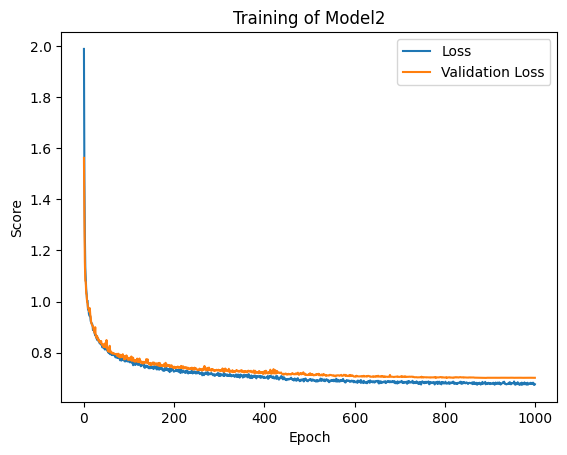

In [37]:
plt.figure()
plt.plot(model2_hist.history['loss'], label='Loss')
plt.plot(model2_hist.history['val_loss'], label='Validation Loss')

plt.title('Training of Model2')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.savefig('exp2.2_training.png')
plt.show()

### Predict + Visualize output

In [68]:
model_name2 = "fatepredict_small_model2"
model2 = sdw.load_stardist_model(model_name=model_name2)

Y_val_pred2 = [model2.predict_instances(x, show_tile_progress=False)[0][0]
              for x in tqdm(X_val2)]

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_small_model2' from folder 'stardist_models'





  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 179ms/step





  8%|▊         | 1/13 [00:32<06:32, 32.68s/it]

1/1 [==============================] - 0s 26ms/step





 15%|█▌        | 2/13 [01:15<07:05, 38.71s/it]

1/1 [==============================] - 0s 26ms/step





 23%|██▎       | 3/13 [02:02<07:05, 42.57s/it]

1/1 [==============================] - 0s 26ms/step





 31%|███       | 4/13 [02:38<05:57, 39.72s/it]

1/1 [==============================] - 0s 25ms/step





 38%|███▊      | 5/13 [03:07<04:46, 35.83s/it]

1/1 [==============================] - 0s 25ms/step





 46%|████▌     | 6/13 [03:47<04:22, 37.50s/it]

1/1 [==============================] - 0s 27ms/step





 54%|█████▍    | 7/13 [04:20<03:35, 35.97s/it]

1/1 [==============================] - 0s 25ms/step





 62%|██████▏   | 8/13 [04:56<02:59, 35.82s/it]

1/1 [==============================] - 0s 27ms/step





 69%|██████▉   | 9/13 [05:32<02:24, 36.08s/it]

1/1 [==============================] - 0s 25ms/step





 77%|███████▋  | 10/13 [06:18<01:57, 39.01s/it]

1/1 [==============================] - 0s 27ms/step





 85%|████████▍ | 11/13 [06:45<01:10, 35.38s/it]

1/1 [==============================] - 0s 25ms/step





 92%|█████████▏| 12/13 [07:14<00:33, 33.45s/it]

1/1 [==============================] - 0s 27ms/step





100%|██████████| 13/13 [07:57<00:00, 36.75s/it]


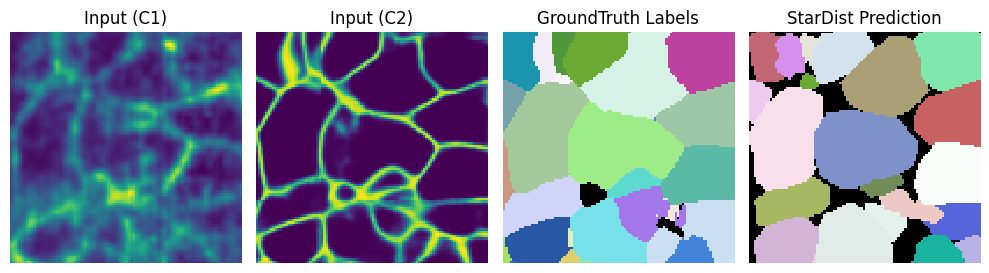

In [60]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 4

fig.add_subplot(rows, columns, 1)
plt.imshow(X_val2[0][10][:,:,0])
plt.axis('off')
plt.title('Input (C1)')

fig.add_subplot(rows, columns, 2)
plt.imshow(X_val2[0][10][:,:,1])
plt.axis('off')
plt.title('Input (C2)')

fig.add_subplot(rows, columns, 3)
plt.imshow(Y_val2[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels')

fig.add_subplot(rows, columns, 4)
plt.imshow(Y_val_pred2[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('StarDist Prediction')

plt.tight_layout()
plt.savefig('exp2.2_model2_stardist_pred.png')
plt.show()


### Measure performance

In [77]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats2 = [matching_dataset(Y_val2, Y_val_pred2, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  7.86it/s]


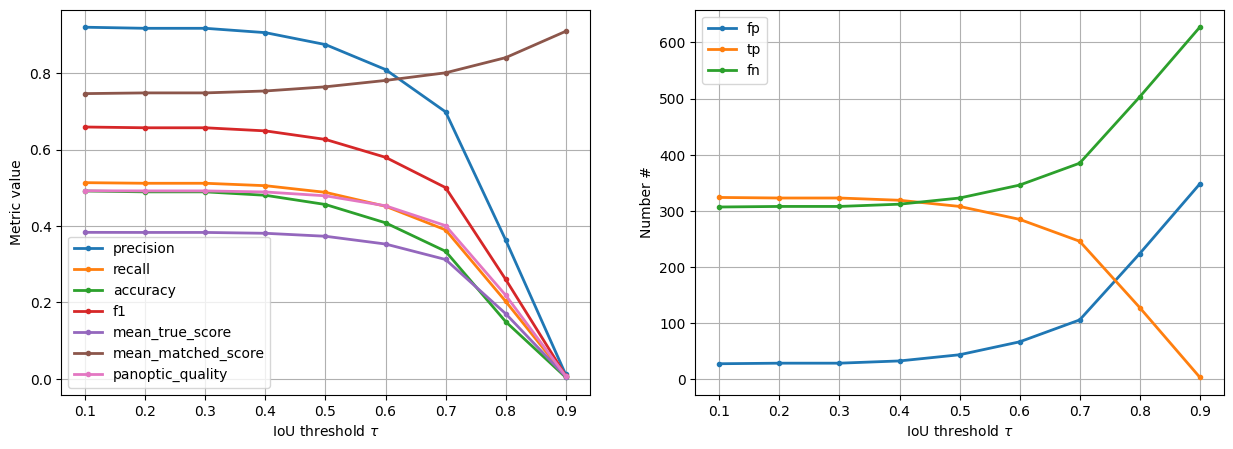

In [204]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats2], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats2], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.savefig('exp2.2_iou_pr_stardist_model2.png')

## Model3
Only plantseg

### Prepare data

In [59]:
# Use 1 channels (plantseg)
for _t in range(max_t):
    for a, _z in enumerate(slice_z):
        for b, _y in enumerate(slice_y):
            for c, _x in enumerate(slice_x):
                ext = 'T%s_Z%s_Y%s_X%s' % (_t, a, b, c)
                file = 'train_m3/data_%s.h5' % ext
                #print(file)
                _plantseg = plantseg[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                
                _X = _plantseg
                _Y = track[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _f = h5py.File(path+file, 'w') # Track file
                _f.create_dataset('X', data=_X)
                _f.create_dataset('Y', data=_Y)
                _f.close()

OSError: Unable to synchronously create file (unable to truncate a file which is already open)

In [43]:
X3, Y3, X_trn3, Y_trn3, X_val3, Y_val3, n_channel3 = \
    load_fatepredict_data(dataset='train_m3', n_channel=1)


100%|██████████| 88/88 [00:00<00:00, 189.29it/s]

number of images:  88
- training:        75
- validation:      13
X[0].shape=(20, 100, 100)


### Visualize data

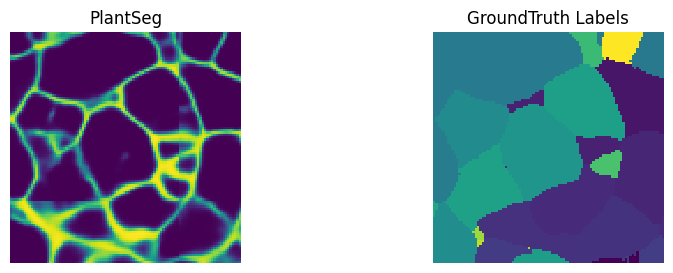

In [68]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(X3[0][10,:,:], cmap='viridis')
plt.axis('off')
plt.title('PlantSeg')

fig.add_subplot(rows, columns, 2)
plt.imshow(Y3[0][10,:,:])
plt.axis('off')
plt.title('GroundTruth Labels')
plt.savefig('exp2.3_training_data.png')
plt.show()

### Configure + train

In [ ]:
model_name3="fatepredict_small_model3"
model3 = sdw.configure(Y3, n_channel3, model_name=model_name3)

model3_hist = model3.train(X_trn3, Y_trn3, validation_data=(X_val3,Y_val3), augmenter=sdw.augmenter, epochs=1000)

empirical anisotropy of labeled objects = (1.8181818181818181, 1.0256410256410255, 1.0)
div_by=(4, 8, 8)
n_dim: 3
axes: ZYXC
n_channel_in: 1
n_channel_out: 97
train_checkpoint: weights_best.h5
train_checkpoint_last: weights_last.h5
train_checkpoint_epoch: weights_now.h5
n_rays: 96
grid: (1, 2, 2)
anisotropy: (1.8181818181818181, 1.0256410256410255, 1.0)
backbone: unet
rays_json: {'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.8181818181818181, 1.0256410256410255, 1.0)}}
n_classes: None
unet_n_depth: 2
unet_kernel_size: (3, 3, 3)
unet_n_filter_base: 32
unet_n_conv_per_depth: 2
unet_pool: (2, 2, 2)
unet_activation: relu
unet_last_activation: relu
unet_batch_norm: False
unet_dropout: 0.0
unet_prefix: 
net_conv_after_unet: 128
net_input_shape: (None, None, None, 1)
net_mask_shape: (None, None, None, 1)
train_patch_size: [20, 32, 32]
train_background_reg: 0.0001
train_foreground_only: 0.9
train_sample_cache: True
train_dist_loss: mae
train_loss_weights: (1, 0.2)
train_cla

base_model.py (149): output path for model already exists, files may be overwritten: /home/jupyter/fatepredict/experiments/stardist_models/fatepredict_small_model3
  0%|          | 0/88 [06:03<?, ?it/s]


median object size:      [11.  19.5 20. ]
network field of view :  [26 46 46]
Epoch 1/1000
100/100 [==============================] - 10s 54ms/step - loss: 2.0842 - prob_loss: 0.6430 - dist_loss: 7.2056 - prob_kld: 0.1205 - dist_relevant_mae: 7.2054 - dist_relevant_mse: 87.7456 - dist_dist_iou_metric: 0.0870 - val_loss: 1.5295 - val_prob_loss: 0.6307 - val_dist_loss: 4.4940 - val_prob_kld: 0.1049 - val_dist_relevant_mae: 4.4935 - val_dist_relevant_mse: 41.9558 - val_dist_dist_iou_metric: 0.2570 - lr: 3.0000e-04
Epoch 2/1000
100/100 [==============================] - 4s 37ms/step - loss: 1.4313 - prob_loss: 0.6060 - dist_loss: 4.1267 - prob_kld: 0.0844 - dist_relevant_mae: 4.1262 - dist_relevant_mse: 35.6308 - dist_dist_iou_metric: 0.3059 - val_loss: 1.3220 - val_prob_loss: 0.5847 - val_dist_loss: 3.6865 - val_prob_kld: 0.0589 - val_dist_relevant_mae: 3.6861 - val_dist_relevant_mse: 30.2144 - val_dist_dist_iou_metric: 0.3287 - lr: 3.0000e-04
Epoch 3/1000
100/100 [=======================

### Training graph

In [ ]:
import pickle

pickle.dump(model3_hist, open( 'model3_hist.pkl', 'wb' ) )

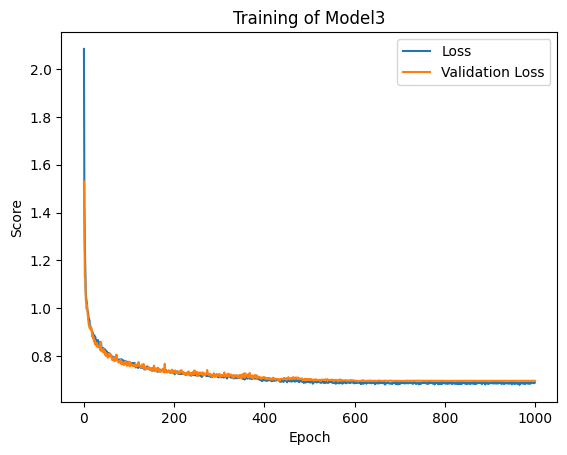

In [82]:
plt.figure()
plt.plot(model3_hist.history['loss'], label='Loss')
plt.plot(model3_hist.history['val_loss'], label='Validation Loss')

plt.title('Training of Model3')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.savefig('exp2.3_training.png')
plt.show()

### Predict + Visualize output

In [67]:
model_name3="fatepredict_small_model3"
model3 = sdw.load_stardist_model(model_name=model_name3)

Y_val_pred3 = [model3.predict_instances(x, show_tile_progress=False)[0][0]
              for x in tqdm(X_val3)]

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_small_model3' from folder 'stardist_models'





  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 177ms/step





  8%|▊         | 1/13 [00:35<07:01, 35.09s/it]

1/1 [==============================] - 0s 26ms/step





 15%|█▌        | 2/13 [01:13<06:49, 37.21s/it]

1/1 [==============================] - 0s 25ms/step





 23%|██▎       | 3/13 [01:59<06:49, 41.00s/it]

1/1 [==============================] - 0s 26ms/step





 31%|███       | 4/13 [02:30<05:34, 37.20s/it]

1/1 [==============================] - 0s 25ms/step





 38%|███▊      | 5/13 [02:56<04:23, 32.99s/it]

1/1 [==============================] - 0s 26ms/step





 46%|████▌     | 6/13 [03:27<03:46, 32.37s/it]

1/1 [==============================] - 0s 26ms/step





 54%|█████▍    | 7/13 [03:56<03:08, 31.42s/it]

1/1 [==============================] - 0s 26ms/step





 62%|██████▏   | 8/13 [04:30<02:39, 31.99s/it]

1/1 [==============================] - 0s 27ms/step





 69%|██████▉   | 9/13 [05:04<02:10, 32.68s/it]

1/1 [==============================] - 0s 25ms/step





 77%|███████▋  | 10/13 [05:41<01:42, 34.03s/it]

1/1 [==============================] - 0s 25ms/step





 85%|████████▍ | 11/13 [06:10<01:04, 32.43s/it]

1/1 [==============================] - 0s 25ms/step





 92%|█████████▏| 12/13 [06:38<00:31, 31.18s/it]

1/1 [==============================] - 0s 24ms/step





100%|██████████| 13/13 [07:14<00:00, 33.46s/it]


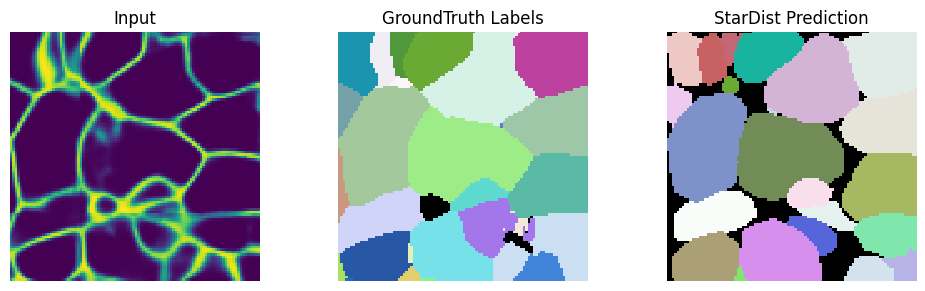

In [61]:
fig = plt.figure(figsize=(10, 3))


rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(X_val3[0][10])
plt.axis('off')
plt.title('Input')

fig.add_subplot(rows, columns, 2)
plt.imshow(Y_val3[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels')

fig.add_subplot(rows, columns, 3)
plt.imshow(Y_val_pred3[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('StarDist Prediction')

plt.tight_layout()
plt.savefig('exp2.3_model3_stardist_pred.png')
plt.show()

### Measure performance

In [78]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats3 = [matching_dataset(Y_val3, Y_val_pred3, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


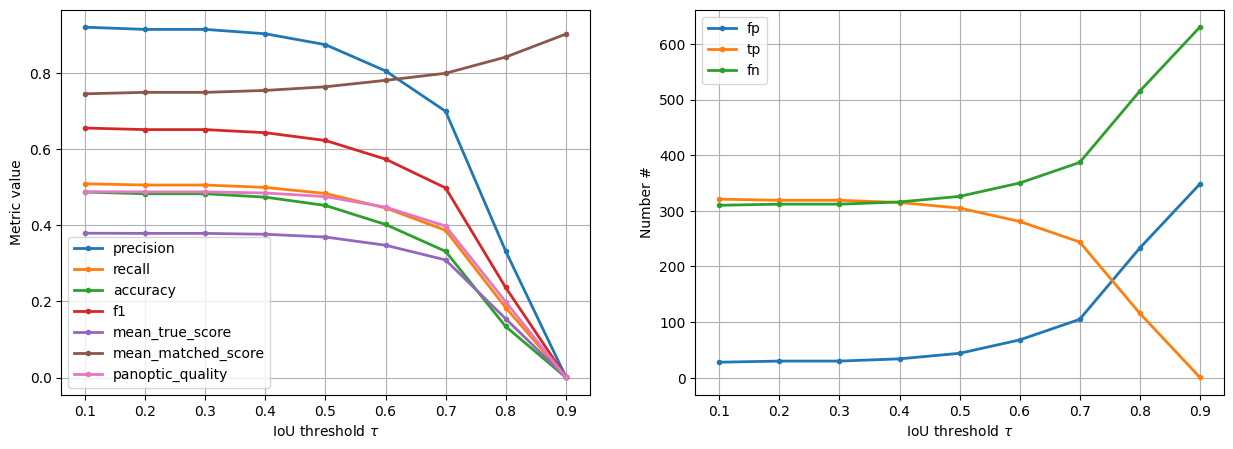

In [193]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats3], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats3], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.savefig('exp2.3_iou_pr_stardist_model3.png')

## Model4
Only C1

### Prepare data

In [65]:
# Use 1 channels (plantseg)
for _t in range(max_t):
    for a, _z in enumerate(slice_z):
        for b, _y in enumerate(slice_y):
            for c, _x in enumerate(slice_x):
                ext = 'T%s_Z%s_Y%s_X%s' % (_t, a, b, c)
                file = 'train_m4/data_%s.h5' % ext
                #print(file)
                _c1 = c1[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                
                _X = _c1
                _Y = track[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _f = h5py.File(path+file, 'w') # Track file
                _f.create_dataset('X', data=_X)
                _f.create_dataset('Y', data=_Y)
                _f.close()

In [40]:
X4, Y4, X_trn4, Y_trn4, X_val4, Y_val4, n_channel4 = \
    load_fatepredict_data(dataset='train_m4', n_channel=1)


100%|██████████| 88/88 [00:00<00:00, 272.46it/s]

number of images:  88
- training:        75
- validation:      13
X[0].shape=(20, 100, 100)


### Visualize data

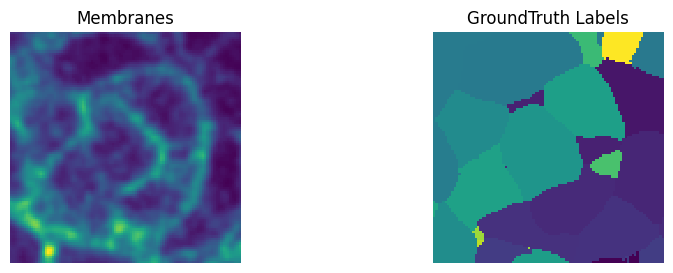

In [74]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(X4[0][10,:,:], cmap='viridis')
plt.axis('off')
plt.title('Membranes')

fig.add_subplot(rows, columns, 2)
plt.imshow(Y4[0][10,:,:])
plt.axis('off')
plt.title('GroundTruth Labels')
plt.savefig('exp2.4_training_data.png')
plt.show()

### Configure + train

In [ ]:
model_name4="fatepredict_small_model4"
model4 = sdw.configure(Y4, n_channel4, model_name=model_name4)

model4_hist = model4.train(X_trn4, Y_trn4, validation_data=(X_val4,Y_val4), augmenter=sdw.augmenter, epochs=1000)

100/100 [==============================] - 10s 55ms/step - loss: 2.0462 - prob_loss: 0.6412 - dist_loss: 7.0253 - prob_kld: 0.1185 - dist_relevant_mae: 7.0251 - dist_relevant_mse: 83.7231 - dist_dist_iou_metric: 0.0996 - val_loss: 1.5452 - val_prob_loss: 0.6318 - val_dist_loss: 4.5671 - val_prob_kld: 0.1024 - val_dist_relevant_mae: 4.5667 - val_dist_relevant_mse: 44.4135 - val_dist_dist_iou_metric: 0.2610 - lr: 3.0000e-04
Epoch 2/1000
100/100 [==============================] - 4s 37ms/step - loss: 1.4410 - prob_loss: 0.6280 - dist_loss: 4.0649 - prob_kld: 0.1079 - dist_relevant_mae: 4.0644 - dist_relevant_mse: 34.3273 - dist_dist_iou_metric: 0.3124 - val_loss: 1.4308 - val_prob_loss: 0.6665 - val_dist_loss: 3.8218 - val_prob_kld: 0.1371 - val_dist_relevant_mae: 3.8213 - val_dist_relevant_mse: 31.2857 - val_dist_dist_iou_metric: 0.3554 - lr: 3.0000e-04
Epoch 3/1000
100/100 [==============================] - 4s 37ms/step - loss: 1.3166 - prob_loss: 0.6238 - dist_loss: 3.4640 - prob_kld: 

### Training graph

In [89]:
import pickle

pickle.dump(model4_hist, open( 'model4_hist.pkl', 'wb' ) )

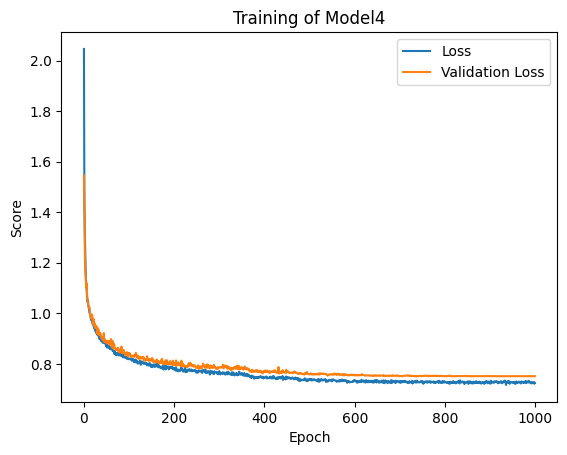

In [90]:
plt.figure()
plt.plot(model4_hist.history['loss'], label='Loss')
plt.plot(model4_hist.history['val_loss'], label='Validation Loss')

plt.title('Training of Model4')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.savefig('exp2.4_training.png')
plt.show()

### Predict + Visualize output

In [ ]:
model_name4="fatepredict_small_model4"
model4 = sdw.load_stardist_model(model_name=model_name4)

Y_val_pred4 = [model4.predict_instances(x, show_tile_progress=False)[0][0]
              for x in tqdm(X_val4)]

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_small_model4' from folder 'stardist_models'





  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 173ms/step





  8%|▊         | 1/13 [00:31<06:19, 31.60s/it]

1/1 [==============================] - 0s 24ms/step





 15%|█▌        | 2/13 [01:06<06:06, 33.30s/it]

1/1 [==============================] - 0s 24ms/step





 23%|██▎       | 3/13 [01:54<06:42, 40.25s/it]

1/1 [==============================] - 0s 24ms/step





 31%|███       | 4/13 [02:25<05:27, 36.43s/it]

1/1 [==============================] - 0s 25ms/step





 38%|███▊      | 5/13 [02:47<04:11, 31.47s/it]

1/1 [==============================] - 0s 28ms/step





 46%|████▌     | 6/13 [03:22<03:48, 32.58s/it]

1/1 [==============================] - 0s 27ms/step





 54%|█████▍    | 7/13 [03:51<03:08, 31.44s/it]

1/1 [==============================] - 0s 26ms/step





 62%|██████▏   | 8/13 [04:24<02:39, 31.91s/it]

1/1 [==============================] - 0s 25ms/step





 69%|██████▉   | 9/13 [05:00<02:12, 33.14s/it]

1/1 [==============================] - 0s 24ms/step





 77%|███████▋  | 10/13 [05:32<01:38, 32.89s/it]

1/1 [==============================] - 0s 26ms/step





 85%|████████▍ | 11/13 [05:59<01:02, 31.09s/it]

1/1 [==============================] - 0s 26ms/step





 92%|█████████▏| 12/13 [06:31<00:31, 31.29s/it]

1/1 [==============================] - 0s 25ms/step





100%|██████████| 13/13 [07:04<00:00, 32.63s/it]


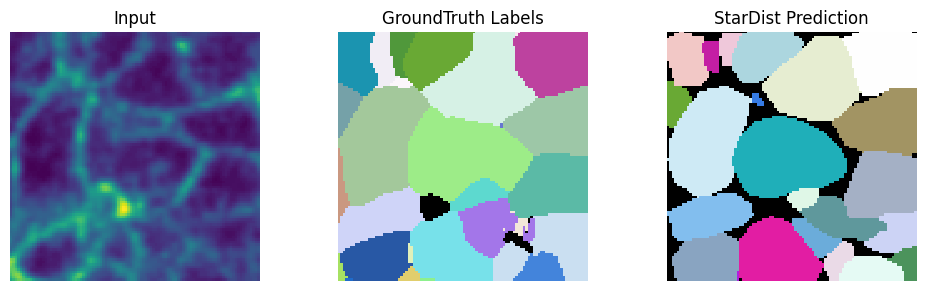

In [63]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(X_val4[0][10])
plt.axis('off')
plt.title('Input')

fig.add_subplot(rows, columns, 2)
plt.imshow(Y_val4[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels')

fig.add_subplot(rows, columns, 3)
plt.imshow(Y_val_pred4[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('StarDist Prediction')

plt.tight_layout()
plt.savefig('exp2.4_model4_stardist_pred.png')
plt.show()

### Measure performance

In [79]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats4 = [matching_dataset(Y_val4, Y_val_pred4, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  7.44it/s]


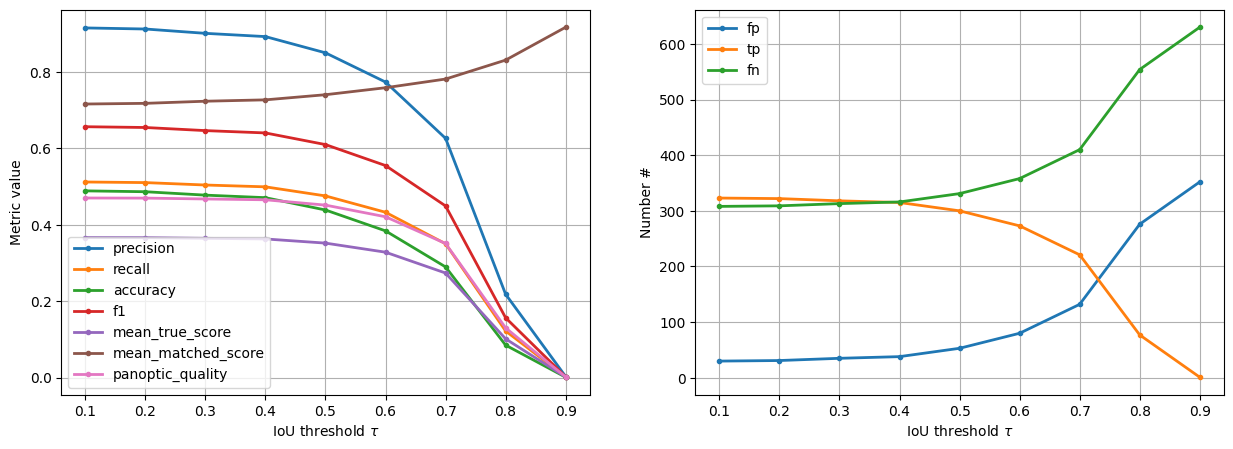

In [187]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats4], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats4], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()

plt.savefig('exp2.4_iou_pr_stardist_model4.png')

## Summary

In [ ]:
print('F1: %s, Acc: %s' % (stats1[taus.index(0.7)].f1, stats1[taus.index(0.7)].accuracy))
print('F1: %s, Acc: %s' % (stats2[taus.index(0.7)].f1, stats2[taus.index(0.7)].accuracy))
print('F1: %s, Acc: %s' % (stats3[taus.index(0.7)].f1, stats3[taus.index(0.7)].accuracy))
print('F1: %s, Acc: %s' % (stats4[taus.index(0.7)].f1, stats4[taus.index(0.7)].accuracy))

F1: 0.5025025025025025, Acc: 0.3355614973262032
F1: 0.5005086469989827, Acc: 0.3337856173677069
F1: 0.49795918367346936, Acc: 0.33152173913043476
F1: 0.4491869918699187, Acc: 0.28964613368283093


## Model5
Eroded GT

### Prepare data

In [125]:
# Erode GT
from scipy import ndimage
from trackers import * 

kernel = np.ones((2, 2, 2), np.uint8) 

for _t in range(max_t):
    for a, _z in enumerate(slice_z):
        for b, _y in enumerate(slice_y):
            for c, _x in enumerate(slice_x):
                ext = 'T%s_Z%s_Y%s_X%s' % (_t, a, b, c)
                file = 'train_m5/data_%s.h5' % ext
                #print(file)
                _plantseg = plantseg[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _track = track[_t, _z:_z+20, _y:_y+100, _x:_x+100]

                # Erode
                _Y = np.zeros(_track.shape, dtype=np.int64)
                for g in np.unique(_track):
                    _mask = mask(_track, g)
                    _mask2 = ndimage.binary_erosion(_mask, structure=kernel)
                    _Y = _Y + _mask2*g
                
                _Y = _Y.astype(int)
                _X = _plantseg
                _f = h5py.File(path+file, 'w') # Track file
                _f.create_dataset('X', data=_X)
                _f.create_dataset('Y', data=_Y)
                _f.close()

In [36]:
X5, Y5, X_trn5, Y_trn5, X_val5, Y_val5, n_channel5 = \
    load_fatepredict_data(dataset='train_m5', n_channel=1)

100%|██████████| 88/88 [00:00<00:00, 211.40it/s]

number of images:  88
- training:        75
- validation:      13
X[0].shape=(20, 100, 100)


### Visualize data

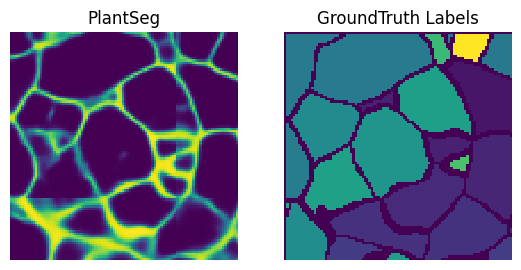

In [129]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(X5[0][10,:,:], cmap='viridis')
plt.axis('off')
plt.title('PlantSeg')

fig.add_subplot(rows, columns, 2)
plt.imshow(Y5[0][10,:,:])
plt.axis('off')
plt.title('GroundTruth Labels')

plt.tight_layout()
plt.show()
plt.savefig('exp2.5_training_data.png')

### Configure + train

In [130]:
model_name5="fatepredict_small_model5"
model5 = sdw.configure(Y5, n_channel5, model_name=model_name5)

model5_hist = model5.train(X_trn5, Y_trn5, validation_data=(X_val5,Y_val5), augmenter=sdw.augmenter, epochs=1000)

empirical anisotropy of labeled objects = (1.7692307692307692, 1.0952380952380953, 1.0)
div_by=(4, 8, 8)
n_dim: 3
axes: ZYXC
n_channel_in: 1
n_channel_out: 97
train_checkpoint: weights_best.h5
train_checkpoint_last: weights_last.h5
train_checkpoint_epoch: weights_now.h5
n_rays: 96
grid: (1, 2, 2)
anisotropy: (1.7692307692307692, 1.0952380952380953, 1.0)
backbone: unet
rays_json: {'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.7692307692307692, 1.0952380952380953, 1.0)}}
n_classes: None
unet_n_depth: 2
unet_kernel_size: (3, 3, 3)
unet_n_filter_base: 32
unet_n_conv_per_depth: 2
unet_pool: (2, 2, 2)
unet_activation: relu
unet_last_activation: relu
unet_batch_norm: False
unet_dropout: 0.0
unet_prefix: 
net_conv_after_unet: 128
net_input_shape: (None, None, None, 1)
net_mask_shape: (None, None, None, 1)
train_patch_size: [20, 32, 32]
train_background_reg: 0.0001
train_foreground_only: 0.9
train_sample_cache: True
train_dist_loss: mae
train_loss_weights: (1, 0.2)
train_cla

base_model.py (149): output path for model already exists, files may be overwritten: /home/jupyter/fatepredict/experiments/stardist_models/fatepredict_small_model5


median object size:      [13. 21. 23.]
network field of view :  [26 46 46]
Epoch 1/500
100/100 [==============================] - ETA: 0s - loss: 2.0563 - prob_loss: 0.5769 - dist_loss: 7.3971 - prob_kld: 0.1504 - dist_relevant_mae: 7.3969 - dist_relevant_mse: 88.0550 - dist_dist_iou_metric: 0.0612WARNING:tensorflow:5 out of the last 3007 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f32e471b400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


100/100 [==============================] - 10s 53ms/step - loss: 2.0563 - prob_loss: 0.5769 - dist_loss: 7.3971 - prob_kld: 0.1504 - dist_relevant_mae: 7.3969 - dist_relevant_mse: 88.0550 - dist_dist_iou_metric: 0.0612 - val_loss: 1.5944 - val_prob_loss: 0.5520 - val_dist_loss: 5.2122 - val_prob_kld: 0.1408 - val_dist_relevant_mae: 5.2119 - val_dist_relevant_mse: 51.8763 - val_dist_dist_iou_metric: 0.1680 - lr: 3.0000e-04
Epoch 2/500
100/100 [==============================] - 4s 36ms/step - loss: 1.3700 - prob_loss: 0.5401 - dist_loss: 4.1495 - prob_kld: 0.1139 - dist_relevant_mae: 4.1491 - dist_relevant_mse: 34.8430 - dist_dist_iou_metric: 0.2996 - val_loss: 1.2191 - val_prob_loss: 0.5139 - val_dist_loss: 3.5259 - val_prob_kld: 0.1028 - val_dist_relevant_mae: 3.5254 - val_dist_relevant_mse: 25.3814 - val_dist_dist_iou_metric: 0.3520 - lr: 3.0000e-04
Epoch 3/500
100/100 [==============================] - 4s 36ms/step - loss: 1.1557 - prob_loss: 0.5000 - dist_loss: 3.2787 - prob_kld: 0.

### Training graph

In [131]:
import pickle

pickle.dump(model5_hist, open( 'model5_hist.pkl', 'wb' ) )

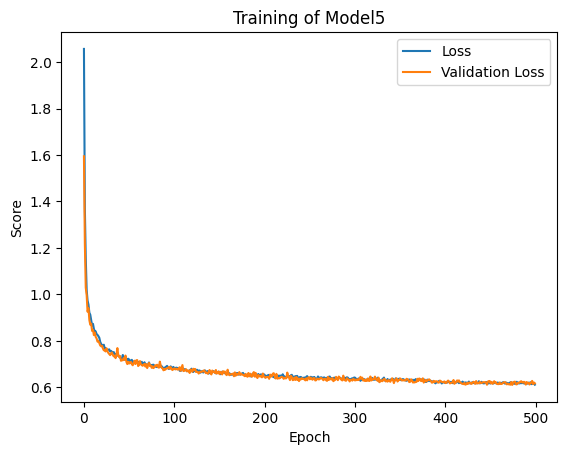

In [132]:
plt.figure()
plt.plot(model5_hist.history['loss'], label='Loss')
plt.plot(model5_hist.history['val_loss'], label='Validation Loss')

plt.title('Training of Model5')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.savefig('exp2.5_training.png')
plt.show()

### Predict + Visualize output

In [ ]:
model_name5="fatepredict_small_model5"
model5 = sdw.load_stardist_model(model_name=model_name5)

Y_val_pred5 = [model5.predict_instances(x, show_tile_progress=False)[0][0]
              for x in tqdm(X_val5)]

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_small_model5' from folder 'stardist_models'





  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 173ms/step





  8%|▊         | 1/13 [00:20<04:05, 20.50s/it]

1/1 [==============================] - 0s 27ms/step





 15%|█▌        | 2/13 [00:44<04:07, 22.47s/it]

1/1 [==============================] - 0s 24ms/step





 23%|██▎       | 3/13 [01:13<04:15, 25.55s/it]

1/1 [==============================] - 0s 26ms/step





 31%|███       | 4/13 [01:38<03:46, 25.12s/it]

1/1 [==============================] - 0s 25ms/step





 38%|███▊      | 5/13 [01:59<03:09, 23.75s/it]

1/1 [==============================] - 0s 26ms/step





 46%|████▌     | 6/13 [02:24<02:50, 24.35s/it]

1/1 [==============================] - 0s 26ms/step





 54%|█████▍    | 7/13 [02:46<02:20, 23.48s/it]

1/1 [==============================] - 0s 26ms/step





 62%|██████▏   | 8/13 [03:12<02:01, 24.25s/it]

1/1 [==============================] - 0s 27ms/step





 69%|██████▉   | 9/13 [03:31<01:30, 22.52s/it]

1/1 [==============================] - 0s 25ms/step





 77%|███████▋  | 10/13 [03:53<01:06, 22.33s/it]

1/1 [==============================] - 0s 25ms/step





 85%|████████▍ | 11/13 [04:18<00:46, 23.17s/it]

1/1 [==============================] - 0s 26ms/step





 92%|█████████▏| 12/13 [04:39<00:22, 22.59s/it]

1/1 [==============================] - 0s 27ms/step





100%|██████████| 13/13 [05:00<00:00, 23.12s/it]


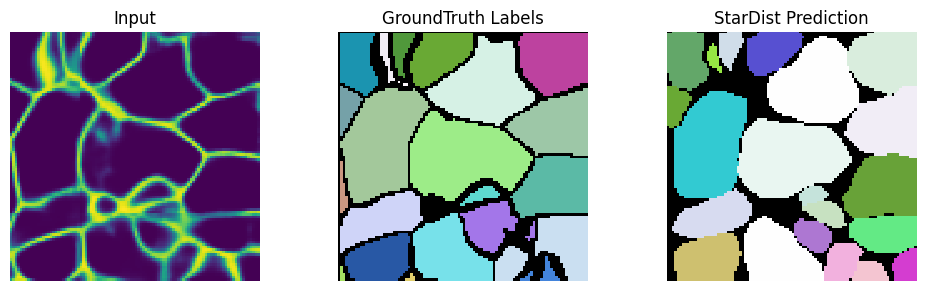

In [64]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(X_val5[0][10])
plt.axis('off')
plt.title('Input')

fig.add_subplot(rows, columns, 2)
plt.imshow(Y_val5[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels')

fig.add_subplot(rows, columns, 3)
plt.imshow(Y_val_pred5[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('StarDist Prediction')

plt.tight_layout()
plt.savefig('exp2.5_model5_stardist_pred.png')
plt.show()

### Measure performance

In [80]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats5 = [matching_dataset(Y_val5, Y_val_pred5, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  6.80it/s]


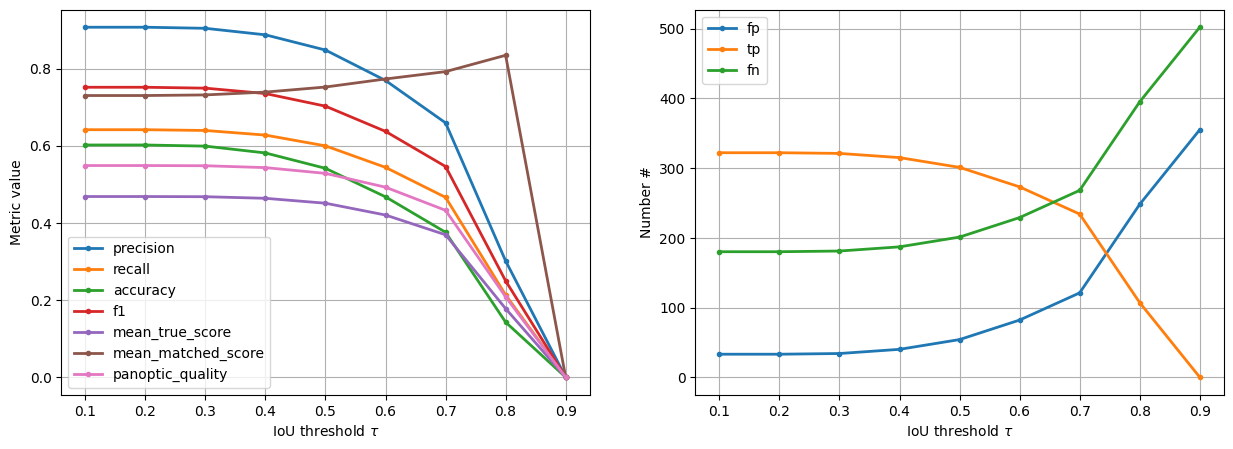

In [172]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats5], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats5], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.savefig('exp2.5_iou_pr_stardist_model5.png')

## Summary

In [218]:
print('F1: %s, Acc: %s' % (stats1[taus.index(0.7)].f1, stats1[taus.index(0.7)].accuracy))
print('F1: %s, Acc: %s' % (stats2[taus.index(0.7)].f1, stats2[taus.index(0.7)].accuracy))
print('F1: %s, Acc: %s' % (stats3[taus.index(0.7)].f1, stats3[taus.index(0.7)].accuracy))
print('F1: %s, Acc: %s' % (stats4[taus.index(0.7)].f1, stats4[taus.index(0.7)].accuracy))
print('F1: %s, Acc: %s' % (stats5[taus.index(0.7)].f1, stats5[taus.index(0.7)].accuracy))

F1: 0.5025025025025025, Acc: 0.3355614973262032
F1: 0.5005086469989827, Acc: 0.3337856173677069
F1: 0.49795918367346936, Acc: 0.33152173913043476
F1: 0.4491869918699187, Acc: 0.28964613368283093
F1: 0.5460910151691949, Acc: 0.3756019261637239


## Model6
- Try model5 with all 3 channels + train for longer

### Prepare data

In [234]:
from scipy import ndimage
from trackers import * 

kernel = np.ones((2, 2, 2), np.uint8) 

for _t in range(max_t):
    for a, _z in enumerate(slice_z):
        for b, _y in enumerate(slice_y):
            for c, _x in enumerate(slice_x):
                ext = 'T%s_Z%s_Y%s_X%s' % (_t, a, b, c)
                file = 'train_m6/data_%s.h5' % ext
                #print(file)
                _c1 = c1[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _c2 = c2[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _plantseg = plantseg[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                _track = track[_t, _z:_z+20, _y:_y+100, _x:_x+100]
                
                # Erode
                _Y = np.zeros(_track.shape, dtype=np.int64)
                for g in np.unique(_track):
                    _mask = mask(_track, g)
                    _mask2 = ndimage.binary_erosion(_mask, structure=kernel)
                    _Y = _Y + _mask2*g
                
                _X = np.stack((_c1, _c2, _plantseg), axis=3) # StarDist requires the deepest axis to be the channels
                _Y = _Y.astype(int)
                _f = h5py.File(path+file, 'w') # Track file
                _f.create_dataset('X', data=_X)
                _f.create_dataset('Y', data=_Y)
                _f.close()

In [9]:
X6, Y6, X_trn6, Y_trn6, X_val6, Y_val6, n_channel6 = \
    load_fatepredict_data(dataset='train_m6', n_channel=3)

100%|██████████| 88/88 [00:01<00:00, 56.38it/s]

number of images:  88
- training:        75
- validation:      13
X[0].shape=(20, 100, 100, 3)


### Visualize data

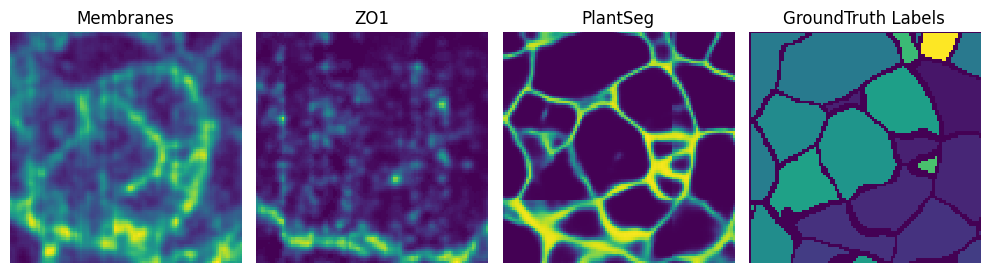

In [55]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 4

fig.add_subplot(rows, columns, 1)
plt.imshow(X6[0][10,:,:,0], cmap='viridis')
plt.axis('off')
plt.title('Membranes')

fig.add_subplot(rows, columns, 2)
plt.imshow(X6[0][10,:,:,1], cmap='viridis')
plt.axis('off')
plt.title('ZO1')

fig.add_subplot(rows, columns, 3)
plt.imshow(X6[0][10,:,:,2], cmap='viridis')
plt.axis('off')
plt.title('PlantSeg')

fig.add_subplot(rows, columns, 4)
plt.imshow(Y6[0][10,:,:])
plt.axis('off')
plt.title('GroundTruth Labels')

plt.tight_layout()
plt.savefig('exp2.6_training_data.png')
plt.show()

### Configure + train

In [ ]:
model_name6="fatepredict_small_model6"
model6 = sdw.configure(Y6, n_channel6, model_name=model_name6)

model6_hist = model6.train(X_trn6, Y_trn6, validation_data=(X_val6, Y_val6), augmenter=sdw.augmenter, epochs=1000)

empirical anisotropy of labeled objects = (1.7692307692307692, 1.0952380952380953, 1.0)
div_by=(4, 8, 8)
n_dim: 3
axes: ZYXC
n_channel_in: 3
n_channel_out: 97
train_checkpoint: weights_best.h5
train_checkpoint_last: weights_last.h5
train_checkpoint_epoch: weights_now.h5
n_rays: 96
grid: (1, 2, 2)
anisotropy: (1.7692307692307692, 1.0952380952380953, 1.0)
backbone: unet
rays_json: {'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.7692307692307692, 1.0952380952380953, 1.0)}}
n_classes: None
unet_n_depth: 2
unet_kernel_size: (3, 3, 3)
unet_n_filter_base: 32
unet_n_conv_per_depth: 2
unet_pool: (2, 2, 2)
unet_activation: relu
unet_last_activation: relu
unet_batch_norm: False
unet_dropout: 0.0
unet_prefix: 
net_conv_after_unet: 128
net_input_shape: (None, None, None, 3)
net_mask_shape: (None, None, None, 1)
train_patch_size: [20, 32, 32]
train_background_reg: 0.0001
train_foreground_only: 0.9
train_sample_cache: True
train_dist_loss: mae
train_loss_weights: (1, 0.2)
train_cla

base_model.py (149): output path for model already exists, files may be overwritten: /home/jupyter/fatepredict/experiments/stardist_models/fatepredict_small_model6


median object size:      [13. 21. 23.]
network field of view :  [26 46 46]
Epoch 1/1000
100/100 [==============================] - 10s 55ms/step - loss: 1.8585 - prob_loss: 0.5600 - dist_loss: 6.4926 - prob_kld: 0.1333 - dist_relevant_mae: 6.4923 - dist_relevant_mse: 72.4748 - dist_dist_iou_metric: 0.1147 - val_loss: 1.4207 - val_prob_loss: 0.5398 - val_dist_loss: 4.4045 - val_prob_kld: 0.1129 - val_dist_relevant_mae: 4.4042 - val_dist_relevant_mse: 40.4759 - val_dist_dist_iou_metric: 0.2274 - lr: 3.0000e-04
Epoch 2/1000
100/100 [==============================] - 4s 39ms/step - loss: 1.3398 - prob_loss: 0.5184 - dist_loss: 4.1071 - prob_kld: 0.0934 - dist_relevant_mae: 4.1067 - dist_relevant_mse: 34.4482 - dist_dist_iou_metric: 0.2925 - val_loss: 1.2206 - val_prob_loss: 0.5072 - val_dist_loss: 3.5670 - val_prob_kld: 0.0804 - val_dist_relevant_mae: 3.5667 - val_dist_relevant_mse: 29.0485 - val_dist_dist_iou_metric: 0.2986 - lr: 3.0000e-04
Epoch 3/1000
100/100 [==========================

### Training graph

In [240]:
import pickle

pickle.dump(model6_hist, open( 'model6_hist.pkl', 'wb' ) )

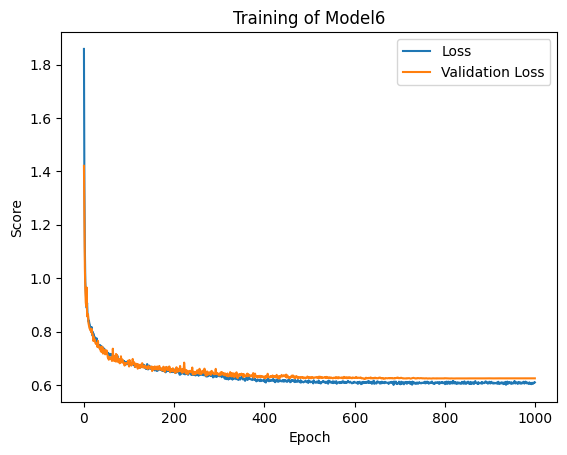

In [241]:
plt.figure()
plt.plot(model6_hist.history['loss'], label='Loss')
plt.plot(model6_hist.history['val_loss'], label='Validation Loss')

plt.title('Training of Model6')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.savefig('exp2.6_training.png')
plt.show()

### Predict + Visualize output

In [ ]:
model_name6="fatepredict_small_model6"
model6 = sdw.load_stardist_model(model_name=model_name6)

Y_val_pred6 = [model6.predict_instances(x, show_tile_progress=False)[0][0]
              for x in tqdm(X_val6)]

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_small_model6' from folder 'stardist_models'





  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 195ms/step





  8%|▊         | 1/13 [00:24<04:50, 24.24s/it]

1/1 [==============================] - 0s 27ms/step





 15%|█▌        | 2/13 [00:49<04:30, 24.55s/it]

1/1 [==============================] - 0s 29ms/step





 23%|██▎       | 3/13 [01:22<04:44, 28.42s/it]

1/1 [==============================] - 0s 26ms/step





 31%|███       | 4/13 [01:51<04:19, 28.79s/it]

1/1 [==============================] - 0s 27ms/step





 38%|███▊      | 5/13 [02:14<03:33, 26.70s/it]

1/1 [==============================] - 0s 27ms/step





 46%|████▌     | 6/13 [02:41<03:07, 26.78s/it]

1/1 [==============================] - 0s 28ms/step





 54%|█████▍    | 7/13 [03:06<02:37, 26.24s/it]

1/1 [==============================] - 0s 27ms/step





 62%|██████▏   | 8/13 [03:34<02:13, 26.75s/it]

1/1 [==============================] - 0s 26ms/step





 69%|██████▉   | 9/13 [03:56<01:41, 25.45s/it]

1/1 [==============================] - 0s 28ms/step





 77%|███████▋  | 10/13 [04:26<01:20, 26.86s/it]

1/1 [==============================] - 0s 27ms/step





 85%|████████▍ | 11/13 [04:50<00:51, 25.94s/it]

1/1 [==============================] - 0s 25ms/step





 92%|█████████▏| 12/13 [05:12<00:24, 24.74s/it]

1/1 [==============================] - 0s 27ms/step





100%|██████████| 13/13 [05:34<00:00, 25.71s/it]


In [74]:
1+1

2

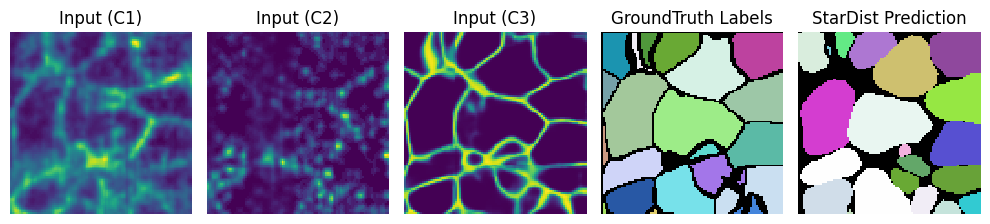

In [65]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 5

fig.add_subplot(rows, columns, 1)
plt.imshow(X_val6[0][10][:,:,0])
plt.axis('off')
plt.title('Input (C1)')

fig.add_subplot(rows, columns, 2)
plt.imshow(X_val6[0][10][:,:,1])
plt.axis('off')
plt.title('Input (C2)')

fig.add_subplot(rows, columns, 3)
plt.imshow(X_val6[0][10][:,:,2])
plt.axis('off')
plt.title('Input (C3)')

fig.add_subplot(rows, columns, 4)
plt.imshow(Y_val6[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels')

fig.add_subplot(rows, columns, 5)
plt.imshow(Y_val_pred6[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('StarDist Prediction')


plt.tight_layout()
plt.savefig('exp2.6_model6_stardist_pred.png')
plt.show()

### Measure performance

In [81]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats6 = [matching_dataset(Y_val6, Y_val_pred6, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


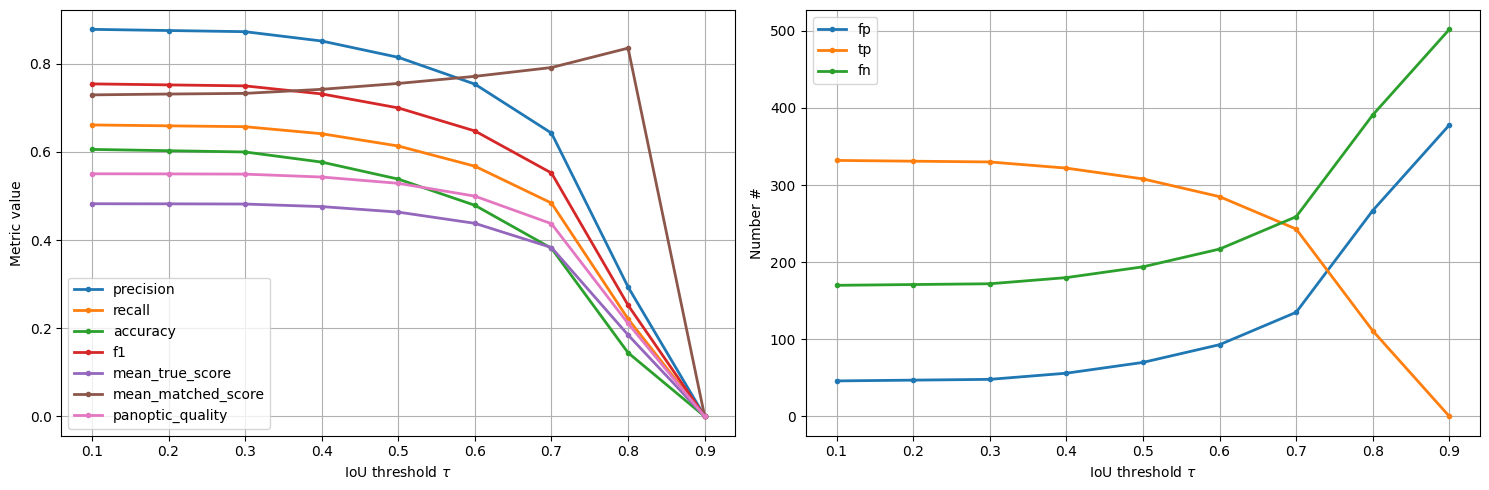

In [58]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats6], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats6], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.savefig('exp2.6_iou_pr_stardist_model6.png')

## Summary

In [100]:
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats1[taus.index(0.5)].f1, stats1[taus.index(0.5)].accuracy, stats1[taus.index(0.7)].f1, stats1[taus.index(0.7)].accuracy, stats1[taus.index(0.9)].f1, stats1[taus.index(0.9)].accuracy))
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats2[taus.index(0.5)].f1, stats2[taus.index(0.5)].accuracy, stats2[taus.index(0.7)].f1, stats2[taus.index(0.7)].accuracy, stats2[taus.index(0.9)].f1, stats2[taus.index(0.9)].accuracy))
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats3[taus.index(0.5)].f1, stats3[taus.index(0.5)].accuracy, stats3[taus.index(0.7)].f1, stats3[taus.index(0.7)].accuracy, stats3[taus.index(0.9)].f1, stats3[taus.index(0.9)].accuracy))
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats4[taus.index(0.5)].f1, stats4[taus.index(0.5)].accuracy, stats4[taus.index(0.7)].f1, stats4[taus.index(0.7)].accuracy, stats4[taus.index(0.9)].f1, stats4[taus.index(0.9)].accuracy))
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats5[taus.index(0.5)].f1, stats5[taus.index(0.5)].accuracy, stats5[taus.index(0.7)].f1, stats5[taus.index(0.7)].accuracy, stats5[taus.index(0.9)].f1, stats5[taus.index(0.9)].accuracy))
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats6[taus.index(0.5)].f1, stats6[taus.index(0.5)].accuracy, stats6[taus.index(0.7)].f1, stats6[taus.index(0.7)].accuracy, stats6[taus.index(0.9)].f1, stats6[taus.index(0.9)].accuracy))

0.639 & 0.469 & 0.503 & 0.336 & 0.01 & 0.00\\
0.627 & 0.456 & 0.501 & 0.334 & 0.01 & 0.00\\
0.622 & 0.452 & 0.498 & 0.332 & 0.00 & 0.00\\
0.610 & 0.439 & 0.449 & 0.290 & 0.00 & 0.00\\
0.702 & 0.541 & 0.546 & 0.376 & 0.00 & 0.00\\
0.700 & 0.538 & 0.552 & 0.381 & 0.00 & 0.00\\


## Model7

### Prepare data

In [105]:
from scipy import ndimage
from trackers import * 

kernel = np.ones((2, 2, 2), np.uint8) 

for _t in range(max_t):
    ext = 'T%s' % (_t)
    file = 'train_m7/data_%s.h5' % ext
    #print(file)
    _c1 = c1[_t]
    _c2 = c2[_t]
    _plantseg = plantseg[_t]
    _track = track[_t]

    # Erode
    _Y = np.zeros(_track.shape, dtype=np.int64)
    for g in np.unique(_track):
        _mask = mask(_track, g)
        _mask2 = ndimage.binary_erosion(_mask, structure=kernel)
        _Y = _Y + _mask2*g

    _X = np.stack((_c1, _c2, _plantseg), axis=3) # StarDist requires the deepest axis to be the channels
    _Y = _Y.astype(int)
    _f = h5py.File(path+file, 'w') # Track file
    _f.create_dataset('X', data=_X)
    _f.create_dataset('Y', data=_Y)
    _f.close()

In [8]:
X7, Y7, X_trn7, Y_trn7, X_val7, Y_val7, n_channel7 = \
    load_fatepredict_data(dataset='train_m7', n_channel=3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.79it/s]

number of images:  11
- training:         9
- validation:       2
X[0].shape=(43, 200, 201, 3)


### Configure + train

In [7]:
model_name7="fatepredict_small_model7"
model7 = sdw.configure(Y7, n_channel7, model_name=model_name7, n_rays=128, unet_kernel_size=(4,4,4), unet_n_conv_per_depth=4)

empirical anisotropy of labeled objects = (1.6216216216216217, 1.0344827586206897, 1.0)
If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
div_by=(4, 8, 8)
n_dim: 3
axes: ZYXC
n_channel_in: 3
n_channel_out: 129
train_checkpoint: weights_best.h5
train_checkpoint_last: weights_last.h5
train_checkpoint_epoch: weights_now.h5
n_rays: 128
grid: (1, 2, 2)
anisotropy: (1.6216216216216217, 1.0344827586206897, 1.0)
backbone: unet
rays_json: {'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 128, 'anisotropy': (1.6216216216216217, 1.0344827586206897, 1.0)}}
n_classes: None
unet_n_depth: 2
unet_kernel_size: (4, 4, 4)
unet_n_filter_base: 32
unet_n_conv_per_depth: 4
unet_pool: (2, 2, 2)
unet_activation: relu
unet_last_activation: relu
unet_batch_norm: False
unet_dropout: 0.0
unet_prefix: 
net_conv_after_unet: 128
net_input_shape: (None, None, None, 3)
net_mask_shape: (None, None, None, 1)
train_patch_size: [40, 64, 64]
train_background_reg: 0.0001
train_

base_model.py (149): output path for model already exists, files may be overwritten: /home/jupyter/fatepredict/experiments/stardist_models/fatepredict_small_model7
2023-12-05 13:45:36.186695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 13:45:36.225011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 13:45:36.226610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but ther

Using default values: prob_thresh=0.5, nms_thresh=0.4.


2023-12-05 13:45:39.924707: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900


median object size:      [18.5 29.  30. ]
network field of view :  [32 64 64]


In [ ]:
model7_hist = model7.train(X_trn7, Y_trn7, validation_data=(X_val7, Y_val7), augmenter=sdw.augmenter, epochs=1000)

Epoch 1/1000
Cause: Unable to locate the source code of <function _gcd_import at 0x7fd09c813400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7fd09c813400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7fd09c813400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-12-05 13:45:56.389232: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fce80137480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 13:45:56.389274: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-12-05 13:45:56.396774: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701783956.505175   99366 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  6/100 [>.............................] - ETA: 37s - loss: 2.7581 - prob_loss: 0.6790 - dist_loss: 10.3956 - prob_kld: 0.2423 - dist_relevant_mae: 10.3956 - dist_relevant_mse: 156.3413 - dist_dist_iou_metric: 1.2677e-04WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1289s vs `on_train_batch_end` time: 0.2263s). Check your callbacks.


100/100 [==============================] - 59s 432ms/step - loss: 2.2650 - prob_loss: 0.6118 - dist_loss: 8.2662 - prob_kld: 0.1772 - dist_relevant_mae: 8.2660 - dist_relevant_mse: 112.0725 - dist_dist_iou_metric: 0.1149 - val_loss: 1.5914 - val_prob_loss: 0.5892 - val_dist_loss: 5.0108 - val_prob_kld: 0.1521 - val_dist_relevant_mae: 5.0102 - val_dist_relevant_mse: 47.1057 - val_dist_dist_iou_metric: 0.3066 - lr: 3.0000e-04
Epoch 2/1000
100/100 [==============================] - 41s 408ms/step - loss: 1.5595 - prob_loss: 0.5901 - dist_loss: 4.8467 - prob_kld: 0.1538 - dist_relevant_mae: 4.8460 - dist_relevant_mse: 44.2445 - dist_dist_iou_metric: 0.3427 - val_loss: 1.4731 - val_prob_loss: 0.5896 - val_dist_loss: 4.4173 - val_prob_kld: 0.1525 - val_dist_relevant_mae: 4.4167 - val_dist_relevant_mse: 38.3299 - val_dist_dist_iou_metric: 0.3561 - lr: 3.0000e-04
Epoch 3/1000
100/100 [==============================] - 41s 407ms/step - loss: 1.3068 - prob_loss: 0.5458 - dist_loss: 3.8050 - prob

### Training graph

In [ ]:
import pickle

pickle.dump(model7_hist, open( 'model7_hist.pkl', 'wb' ) )

In [13]:
model7_hist = pickle.load(open( 'model7_hist.pkl', 'rb' ) )

TypeError: Could not locate function 'dist_loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'dist_loss', 'registered_name': 'function'}

In [12]:
plt.figure()
plt.plot(model7_hist.history['loss'], label='Loss')
plt.plot(model7_hist.history['val_loss'], label='Validation Loss')

plt.title('Training of Model7')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.savefig('exp2.7_training.png')
plt.show()

2023-12-06 08:20:18.560719: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 08:20:21.259752: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 08:20:21.262880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

TypeError: Could not locate function 'dist_loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'dist_loss', 'registered_name': 'function'}

### Predict + Visualize output

In [8]:
model_name7="fatepredict_small_model7"
model7 = sdw.load_stardist_model(model_name=model_name7)

Y_val_pred7_all = [model7.predict_instances(x, show_tile_progress=False)
              for x in tqdm(X_val7)]

2023-12-06 16:05:50.319785: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 16:05:53.007703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 16:05:53.010910: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_small_model7' from folder 'stardist_models'


  0%|          | 0/2 [00:00<?, ?it/s]2023-12-06 16:06:15.798926: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900


1/1 [==============================] - 49s 49s/step


 50%|█████     | 1/2 [18:06<18:06, 1086.93s/it]

1/1 [==============================] - 0s 43ms/step


100%|██████████| 2/2 [34:47<00:00, 1043.88s/it]


In [9]:
# Pickle predictions
import pickle
pickle.dump(Y_val_pred7_all, open( 'Y_val_pred7_all.pkl', 'wb' ) )

In [6]:
Y_val_pred7_all = pickle.load(open( 'Y_val_pred7_all.pkl', 'rb' ) )
Y_val_pred7 = [x[0][0] for x in Y_val_pred7_all]

In [ ]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 5

fig.add_subplot(rows, columns, 1)
plt.imshow(X_val7[0][10][:,:,0])
plt.axis('off')
plt.title('Input (C1)')

fig.add_subplot(rows, columns, 2)
plt.imshow(X_val7[0][10][:,:,1])
plt.axis('off')
plt.title('Input (C2)')

fig.add_subplot(rows, columns, 3)
plt.imshow(X_val7[0][10][:,:,2])
plt.axis('off')
plt.title('Input (C3)')

fig.add_subplot(rows, columns, 4)
plt.imshow(Y_val7[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels')

fig.add_subplot(rows, columns, 5)
plt.imshow(Y_val_pred7[0][10], cmap=lbl_cmap)
plt.axis('off')
plt.title('StarDist Prediction')


plt.tight_layout()
plt.savefig('exp2.7_model7_stardist_pred.png')
plt.show()

#### Napari

In [29]:
import napari
viewer = napari.Viewer()
viewer.add_image(X_val7[0][:,:,:,0], name='Raw')
viewer.add_image(X_val7[0][:,:,:,1], name='C2')
viewer.add_image(X_val7[0][:,:,:,2], name='PlantSeg')
viewer.add_labels(Y_val7[0][:,:,:], name='GroundTruth')

viewer.add_image(Y_val_pred7_all[0][1], name='StarDist Map')
viewer.add_labels(Y_val_pred7_all[0][0][0], name='StarDist Prediction')

<Labels layer 'StarDist Prediction' at 0x301d22130>

In [30]:
show_gt = Y_val7[0][:,:,:]
filter_gt = (show_gt==40) | (show_gt==231)| (show_gt==230) | (show_gt==263)

show_pred = Y_val_pred7_all[0][0][0]
filter_pred = (show_pred==10) | (show_pred==56) | (show_pred==77) | (show_pred==8)

viewer = napari.Viewer()
viewer.add_labels(show_gt*filter_gt, name='GroundTruth')
viewer.add_labels(show_pred*filter_pred, name='StarDist Prediction')

<Labels layer 'StarDist Prediction' at 0x3014e7730>

2023-12-06 18:47:44.003 python3.8[98008:15451012] +[CATransaction synchronize] called within transaction
2023-12-06 18:47:45.668 python3.8[98008:15451012] +[CATransaction synchronize] called within transaction
2023-12-06 18:47:47.322 python3.8[98008:15451012] +[CATransaction synchronize] called within transaction


### Measure performance

In [9]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats7 = [matching_dataset(Y_val7, Y_val_pred7, thresh=t, show_progress=False) for t in tqdm(taus)]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.70it/s]


In [17]:
print('F1: %s, Acc: %s' % (stats7[taus.index(0.7)].f1, stats7[taus.index(0.7)].accuracy))

F1: 0.6844583987441131, Acc: 0.5202863961813843


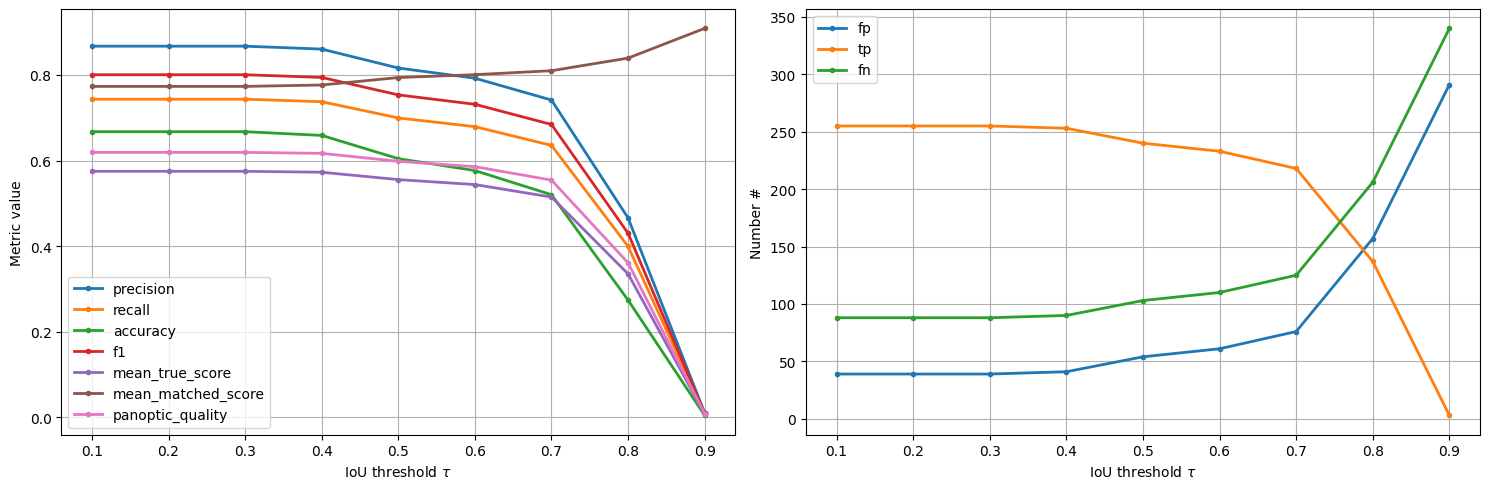

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats7], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats7], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.savefig('exp2.7_iou_pr_stardist_model7.png')

## Summary

In [18]:
print('%.3f & %.3f & %.3f & %.3f & %.2f & %.2f\\\\' % (stats7[taus.index(0.5)].f1, stats7[taus.index(0.5)].accuracy, stats7[taus.index(0.7)].f1, stats7[taus.index(0.7)].accuracy, stats7[taus.index(0.9)].f1, stats7[taus.index(0.9)].accuracy))

0.754 & 0.605 & 0.684 & 0.520 & 0.01 & 0.00\\


## Model8

### Prepare data

### Configure + train

In [ ]:
model_name8="fatepredict_small_model8"
model8 = sdw.configure(Y7, n_channel7, model_name=model_name8)

In [ ]:
model8_hist = model8.train(X_trn7, Y_trn7, validation_data=(X_val7, Y_val7), augmenter=sdw.augmenter, epochs=500)

100/100 [==============================] - 20s 203ms/step - loss: 0.8669 - prob_loss: 0.4773 - dist_loss: 1.9483 - prob_kld: 0.0421 - dist_relevant_mae: 1.9478 - dist_relevant_mse: 10.3405 - dist_dist_iou_metric: 0.6536 - val_loss: 0.8869 - val_prob_loss: 0.4837 - val_dist_loss: 2.0159 - val_prob_kld: 0.0389 - val_dist_relevant_mae: 2.0154 - val_dist_relevant_mse: 11.0270 - val_dist_dist_iou_metric: 0.6328 - lr: 3.0000e-04
Epoch 19/500
100/100 [==============================] - 19s 193ms/step - loss: 0.8541 - prob_loss: 0.4740 - dist_loss: 1.9008 - prob_kld: 0.0384 - dist_relevant_mae: 1.9003 - dist_relevant_mse: 9.8855 - dist_dist_iou_metric: 0.6603 - val_loss: 0.8701 - val_prob_loss: 0.4826 - val_dist_loss: 1.9373 - val_prob_kld: 0.0378 - val_dist_relevant_mae: 1.9368 - val_dist_relevant_mse: 9.7392 - val_dist_dist_iou_metric: 0.6605 - lr: 3.0000e-04
Epoch 20/500
100/100 [==============================] - 19s 192ms/step - loss: 0.8485 - prob_loss: 0.4728 - dist_loss: 1.8783 - prob_kl

### Training graph

In [15]:
import pickle

pickle.dump(model8_hist, open( 'model8_hist.pkl', 'wb' ) )

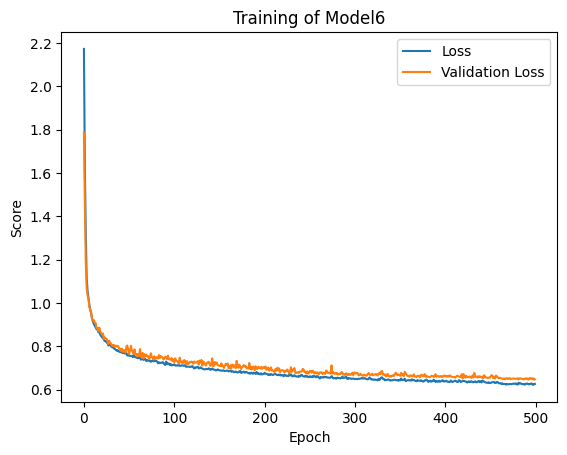

In [16]:
plt.figure()
plt.plot(model8_hist.history['loss'], label='Loss')
plt.plot(model8_hist.history['val_loss'], label='Validation Loss')

plt.title('Training of Model6')
plt.legend(loc = 'upper right')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.savefig('exp2.8_training.png')
plt.show()

### Predict + Visualize output

In [ ]:
model_name8="fatepredict_small_model8"
model8 = sdw.load_stardist_model(model_name=model_name8)

Y_val_pred8 = [model8.predict_instances(x, show_tile_progress=False)[0][0]
              for x in tqdm(X_val7)]

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_small_model8' from folder 'stardist_models'


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


 50%|█████     | 1/2 [12:08<12:08, 728.82s/it]

1/1 [==============================] - 0s 42ms/step


In [23]:
# Pickle predictions
import pickle
pickle.dump(Y_val_pred8, open( 'Y_val_pred8.pkl', 'wb' ) )

In [19]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats8 = [matching_dataset(Y_val7, Y_val_pred8, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  5.11it/s]


In [20]:
print('F1: %s, Acc: %s' % (stats8[taus.index(0.7)].f1, stats8[taus.index(0.7)].accuracy))

F1: 0.6624605678233438, Acc: 0.49528301886792453


# Compare with WaterZ

In [15]:
waterz_stats = pickle.load(open( '1_waterz_stats.pkl', 'rb' ) )

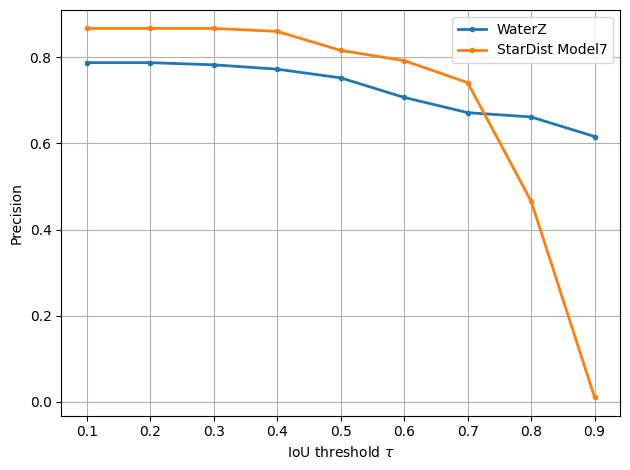

In [25]:
plt.figure()

plt.plot(taus, [s['precision'] for s in waterz_stats['stats']], '.-', lw=2, label='WaterZ')
plt.plot(taus, [s._asdict()['precision'] for s in stats7], '.-', lw=2, label='StarDist Model7')

#plt.xticks(hota2.array_labels)
plt.xlabel(r'IoU threshold $\tau$')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('2_all_precision.png')

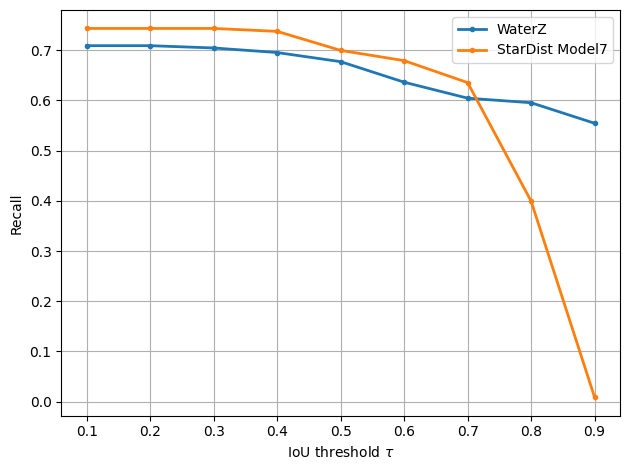

In [26]:
plt.figure()

plt.plot(taus, [s['recall'] for s in waterz_stats['stats']], '.-', lw=2, label='WaterZ')
plt.plot(taus, [s._asdict()['recall'] for s in stats7], '.-', lw=2, label='StarDist Model7')

#plt.xticks(hota2.array_labels)
plt.xlabel(r'IoU threshold $\tau$')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('2_all_recall.png')

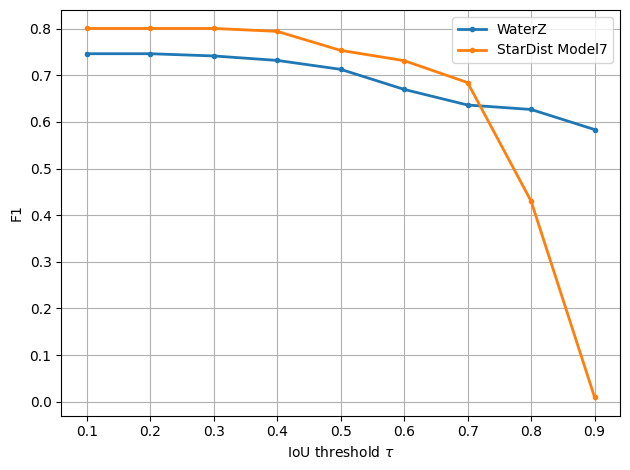

In [27]:
plt.figure()

plt.plot(taus, [s['f1'] for s in waterz_stats['stats']], '.-', lw=2, label='WaterZ')
plt.plot(taus, [s._asdict()['f1'] for s in stats7], '.-', lw=2, label='StarDist Model7')

#plt.xticks(hota2.array_labels)
plt.xlabel(r'IoU threshold $\tau$')
plt.ylabel('F1')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('2_all_f1.png')

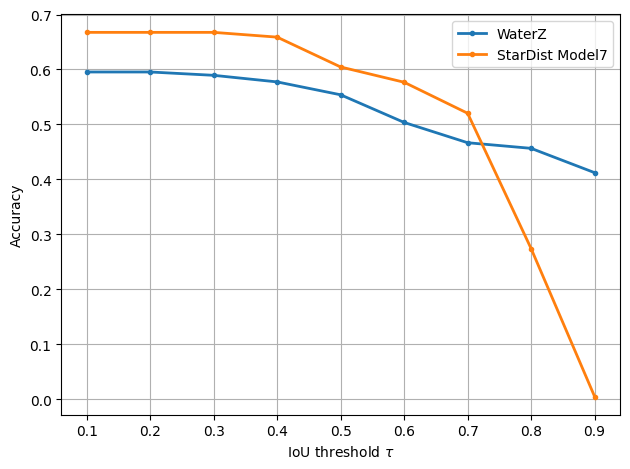

In [28]:
plt.figure()

plt.plot(taus, [s['accuracy'] for s in waterz_stats['stats']], '.-', lw=2, label='WaterZ')
plt.plot(taus, [s._asdict()['accuracy'] for s in stats7], '.-', lw=2, label='StarDist Model7')

#plt.xticks(hota2.array_labels)
plt.xlabel(r'IoU threshold $\tau$')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('2_all_acc.png')